In [1]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.modeling import models, fitting
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy import stats
import photutils
import math
import astroalign as asa
from statistics import mean
import os

# S/N Calculation

In [2]:
magnitude_max = 7.2
magnitude_min = 12
C = 299792458*10**10 #in Angstrom
lamb = 5500 #in Angstrom
f_lambda = {}
count_sec = {}
calibration = 15.28

In [3]:
for mag in [magnitude_max, magnitude_min]:
    f_freq = 3631*10**(-23)*10**(-mag/2.5)
    f_lambda[mag] = f_freq*C/lamb**2
    #electrons per second on each pixel
    count_sec[mag] = 10**calibration * f_lambda[mag]
    print(f"estimated count per second at magnitude {mag}: {count_sec[mag]}")
    exposure_time = 4
    N_star = count_sec[mag]*exposure_time
    print(f"estimated number of counts at magnitude {mag} for exp {exposure_time}s: {N_star}")
    npix = 7**2*math.pi
    N_bkg = 0.4*exposure_time
    N_dark = 0.05*exposure_time
    N_read = 9
    s_n = N_star / math.sqrt(N_star + npix * (N_bkg + N_dark + N_read**2))
    print(f"estimated signal to noise ratio at magnitude {mag}: {s_n}\n")


estimated count per second at magnitude 7.2: 9039.024693890478
estimated number of counts at magnitude 7.2 for exp 4s: 36156.09877556191
estimated signal to noise ratio at magnitude 7.2: 163.49990526293905

estimated count per second at magnitude 12: 108.6729791309307
estimated number of counts at magnitude 12 for exp 4s: 434.6919165237228
estimated signal to noise ratio at magnitude 12: 3.7862676527353276



In [4]:
#Example of how to open a file
bias0 = fits.open("./dataM103/bias_000bias.fit")
print(bias0.info(),'\n'*2)
print(bias0[0].data)


Filename: ./dataM103/bias_000bias.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (4499, 3599)   int16 (rescales to uint16)   
None 


[[343 407 383 ... 343 375 388]
 [362 373 388 ... 340 363 411]
 [346 355 351 ... 403 379 392]
 ...
 [382 358 397 ... 478 445 462]
 [378 352 355 ... 415 401 490]
 [381 407 402 ... 402 467 433]]


# Bias

In [5]:
files_bias = glob.glob("./dataM103/*bias*.fit")

In [6]:
#plt.imshow(bias0[0].data,vmin=0,vmax=100)

In [7]:
def stacking(files,normalize=False,unbias=False):
    allpic=[]
    npic=0
    for ii, bb in enumerate(files) :
        mypic=fits.open(bb)
        allpic.append(mypic[0].data)
        mypic.close()
        npic+=1
    allpic=np.array(allpic)
    #print('Shape of stack', allpic.shape)
    meanval=np.mean(allpic, axis=0)
    if type(unbias) == np.ndarray:
        meanval = meanval - unbias
    if normalize:
        meanval = meanval/(np.mean(meanval))
    #print("Shape of array", meanval.shape)
    return meanval
    
meanbias = stacking(files_bias)
plt.clf()


<Figure size 640x480 with 0 Axes>

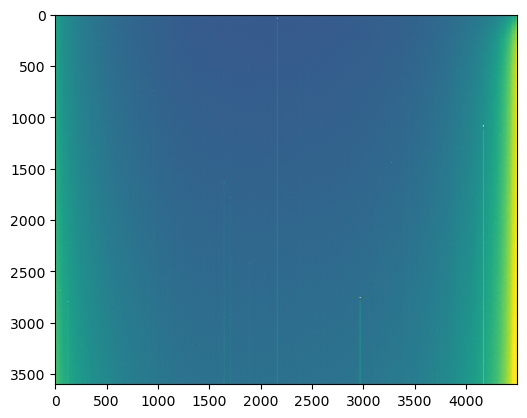

In [8]:
plt.imshow(meanbias,clim=[300,400])

In [9]:
# plt.hist(meanbias.flatten(),bins=30,density=False,log=True)

# Flat

In [10]:
files_flat_Ha = glob.glob("./dataM103/*flat*Ha.fit")
files_flat_OIII = glob.glob("./dataM103/*flat*OIII.fit")
files_flat_SII = glob.glob("./dataM103/*flat*SII.fit")

In [11]:
mean_flat_Ha = stacking(files_flat_Ha,unbias=meanbias,normalize=True)

In [12]:
#plt.hist(mean_flat_Ha.flatten(),bins=10,density=True,log=True)

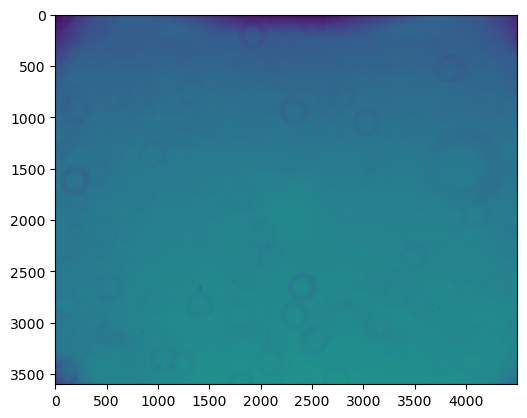

In [13]:
plt.imshow(mean_flat_Ha,clim=[0.8,1.3])

In [14]:
mean_flat_OIII = stacking(files_flat_OIII,unbias=meanbias,normalize=True)

In [15]:
# plt.hist(mean_flat_OIII.flatten(),bins=10,density=True,log=True)

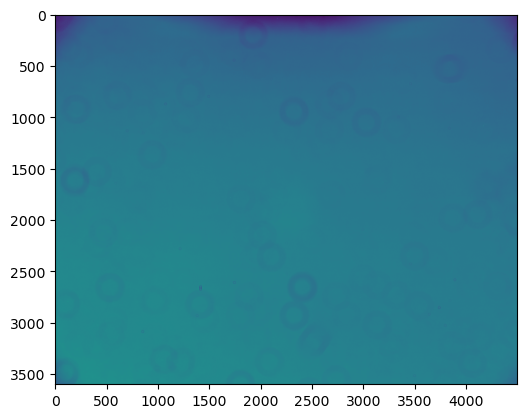

In [16]:
plt.imshow(mean_flat_OIII,clim=[0.8,1.3])

In [17]:
mean_flat_SII = stacking(files_flat_SII,unbias=meanbias,normalize=True)

In [18]:
# plt.hist(mean_flat_SII.flatten(),bins=10,density=True,log=True)

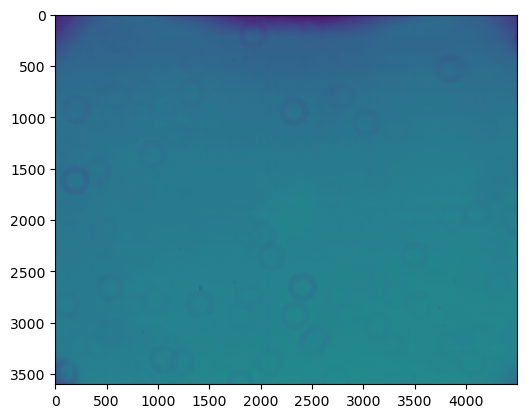

In [19]:
plt.imshow(mean_flat_SII,clim=[0.8,1.3])

# Data

In [20]:
data0 = fits.open("./dataM103/FSR0581_000Ha.fit")

In [21]:
data_files = glob.glob("./dataM103/M103*.fit")
calib_star = glob.glob("./dataM103/HD3360*.fit")

In [22]:
processed_images={}
for f in data_files:
    data = fits.open(f)
    if "Ha" in f:
        flat_data=mean_flat_Ha
    elif "OIII" in f:
        flat_data=mean_flat_OIII
    elif "SII" in f:
        flat_data=mean_flat_SII
    else:
        print('Cannot find filter type in image title')
    proc = (data[0].data-meanbias)/flat_data
    data.close()
    processed_images[f.split('/')[-1]]=proc*0.6

In [23]:
processed_calibration={}
for ca in calib_star:
    data = fits.open(ca)
    if "Ha" in ca:
        flat_data=mean_flat_Ha
    elif "OIII" in ca:
        flat_data=mean_flat_OIII
    elif "SII" in ca:
        flat_data=mean_flat_SII
    else:
        print('Cannot find filter type in image title')
    proc = (data[0].data-meanbias)/flat_data
    data.close()
    processed_calibration[ca.split('/')[-1]]=proc*0.6

In [24]:
processed_calibration.keys()

dict_keys(['HD3360_003Ha.fit', 'HD3360_003OIII.fit', 'HD3360_001Ha.fit', 'HD3360_002OIII.fit', 'HD3360_003SII.fit', 'HD3360_002Ha.fit', 'HD3360_001OIII.fit', 'HD3360_001SII.fit', 'HD3360_002SII.fit'])

In [25]:
processed_images.keys()

dict_keys(['M103_003OIII300s.fit', 'M103_003Ha300s.fit', 'M103_002Ha300s.fit', 'M103_002SII300s.fit', 'M103_004Ha300s.fit', 'M103_001SII300s.fit', 'M103_001Ha300s.fit', 'M103_002OIII300s.fit', 'M103_004SII300s.fit', 'M103_003SII300s.fit', 'M103_001OIII300s.fit', 'M103_004OIII300s.fit'])

## Dust on filters?

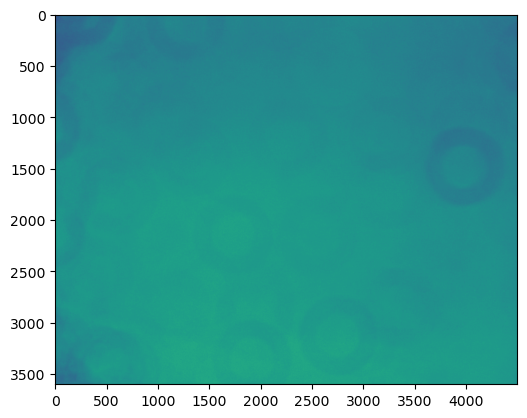

In [26]:
#Difference between filters
plt.imshow(mean_flat_Ha/mean_flat_SII,clim=[0.9,1.1])

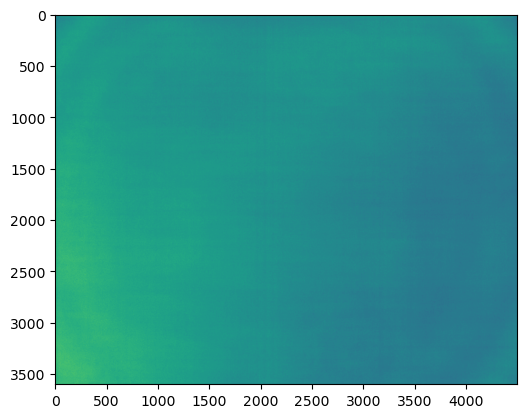

In [27]:
plt.imshow(mean_flat_OIII/mean_flat_SII,clim=[0.9,1.1])

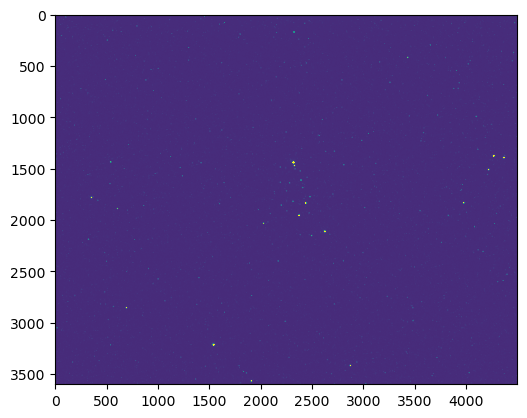

In [28]:
plt.imshow(processed_images['M103_003OIII300s.fit'],clim=[0,1000])

# Dark current

In [29]:
dark_files = glob.glob("./dataM103/*dark*.fit")

In [30]:
dark_files

['./dataM103/calib_044dark120.fit',
 './dataM103/calib_037dark60.fit',
 './dataM103/dark_008_60s.fit',
 './dataM103/dark_013_10s.fit',
 './dataM103/dark_003_10s.fit',
 './dataM103/dark_000_1s.fit',
 './dataM103/dark_012_1s.fit',
 './dataM103/dark_001_60s.fit',
 './dataM103/dark_011_60s.fit',
 './dataM103/calib_040dark60.fit',
 './dataM103/calib_037dark120.fit',
 './dataM103/dark_010_1s.fit',
 './dataM103/dark_002_1s.fit',
 './dataM103/dark_010_60s.fit',
 './dataM103/dark_000_60s.fit',
 './dataM103/calib_041dark120.fit',
 './dataM103/calib_046dark60.fit',
 './dataM103/dark_009_60s.fit',
 './dataM103/dark_002_10s.fit',
 './dataM103/dark_012_10s.fit',
 './dataM103/calib_038dark120.fit',
 './dataM103/dark_006_1s.fit',
 './dataM103/dark_014_1s.fit',
 './dataM103/dark_009_10s.fit',
 './dataM103/calib_036dark60.fit',
 './dataM103/dark_002_60s.fit',
 './dataM103/dark_012_60s.fit',
 './dataM103/calib_046dark120.fit',
 './dataM103/calib_035dark120.fit',
 './dataM103/dark_010_10s.fit',
 './dataM1

In [31]:
darkdict = {}
for dark in dark_files:
    data = fits.open(dark)
    expo = data[0].header['EXPTIME']
    darkdict.setdefault(expo, [])
    darkdict[expo].append(dark)
    data.close()

In [32]:
darkdict.keys()

dict_keys([120.0, 60.0, 10.0, 1.0])

In [33]:
dark_stacked = {}
for espos in darkdict.keys():
    dark_stacked[espos] = stacking(darkdict[espos],unbias=meanbias)*0.6

In [34]:
dark_stacked[120].shape

(3599, 4499)

## Dark Current Averaged

A single dark current is calculated for the whole sensor regardless pixel position

In [35]:
slope, intercept, r, p, std_err = stats.linregress(list(dark_stacked.keys()), [dark_stacked[i].mean() for i in dark_stacked.keys()])
print("Slope:",slope)
print("Intercept:",intercept)
print("R:",r)
print("P:",p)
print("Std_err:",std_err)

Slope: 0.040256695242345465
Intercept: -0.22053639431658878
R: 0.9936419869164714
P: 0.0063580130835285695
Std_err: 0.003225354698672376


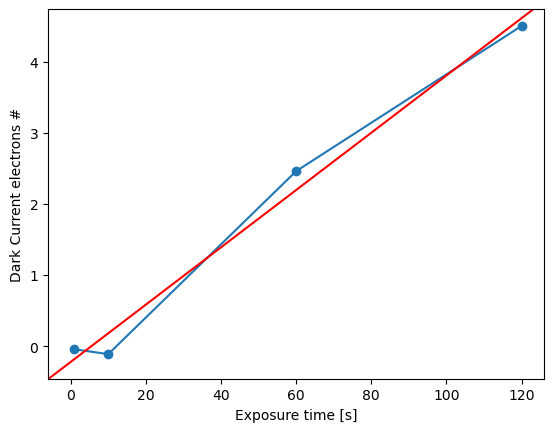

In [36]:
fig, ax = plt.subplots()
ax.plot(list(dark_stacked.keys()),[dark_stacked[i].mean() for i in dark_stacked.keys()],linestyle="-",marker="o")
plt.xlabel("Exposure time [s]")
plt.ylabel("Dark Current electrons #")
ax.axline((0, intercept), slope=slope, color='red', label='by slope')

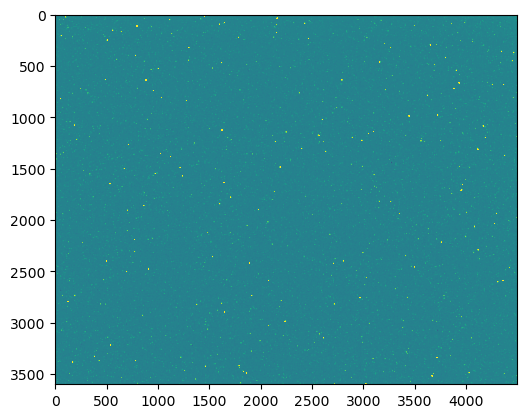

In [37]:
plt.imshow(dark_stacked[60],clim=[-20,30])

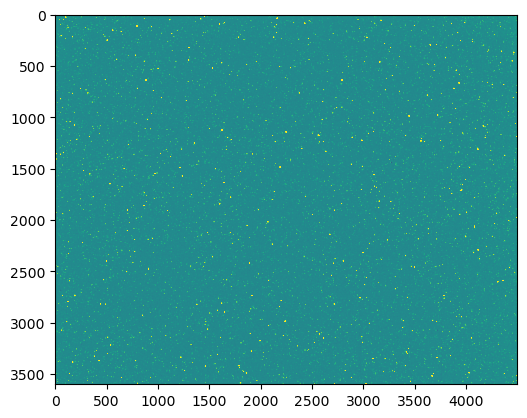

In [38]:
plt.imshow(dark_stacked[120],clim=[-20,30])

## Dark Current Pixelwise

Dark current is calculated per pixel, only the with count higher than the 0.999 quantile are considered (16k instead of 16M as they are reduced by a factor of 1000)

In [39]:
limit = np.quantile(dark_stacked[120], 0.999)
limit

124.57999999999998

In [40]:
if not os.path.exists("currents.npz"):
    currents = np.zeros((3599, 4499))
    c=0
    
    for i in range(currents.shape[0]):
        for j in range(currents.shape[1]):
            if dark_stacked[120][i][j] > limit:
                currents[i][j] = stats.linregress(list(dark_stacked.keys()), [dark_stacked[k][i][j] for k in dark_stacked.keys()])[0]
                lista_pixel.append((i,j))
                c+=1
    print(c)
    np.savez_compressed("currents.npz",currents)
else:
    currents=np.load("currents.npz")['arr_0']

In [41]:
# The dark current calculated on the first 160k brighter pixels is much higher than the one calculated on the whole sensor
currents[currents>0].mean()

5.289879239111844

## Dark Current Subtraction

In [42]:
len(processed_images.keys())
len(processed_calibration.keys())

9

In [43]:
expodict = {}
for img in list(processed_images.keys())[:6]:
    data = fits.open("./dataM103/"+img)
    expodict[img] = data[0].header['EXPTIME']
    data.close()

In [44]:
for img in list(processed_images.keys())[6:]:
    data = fits.open("./dataM103/"+img)
    expodict[img] = data[0].header['EXPTIME']
    data.close()

In [45]:
for img in list(processed_calibration.keys())[:5]:
    data = fits.open("./dataM103/"+img)
    expodict[img] = data[0].header['EXPTIME']
    data.close()

In [46]:
for img in list(processed_calibration.keys())[5:]:
    data = fits.open("./dataM103/"+img)
    expodict[img] = data[0].header['EXPTIME']
    data.close()

In [47]:
processed_images_wo_dark = {}
for k in list(processed_images.keys())[:4]:
    processed_images_wo_dark[k] = processed_images[k] - currents * expodict[k]

In [48]:
for k in list(processed_images.keys())[4:8]:
    processed_images_wo_dark[k] = processed_images[k] - currents * expodict[k]

In [49]:
for k in list(processed_images.keys())[8:]:
    processed_images_wo_dark[k] = processed_images[k] - currents * expodict[k]

In [50]:
processed_calibration_wo_dark = {}
for k in list(processed_calibration.keys())[:3]:
    processed_calibration_wo_dark[k] = processed_calibration[k] - currents * expodict[k]

In [51]:
for k in list(processed_calibration.keys())[3:6]:
    processed_calibration_wo_dark[k] = processed_calibration[k] - currents * expodict[k]

In [52]:
for k in list(processed_calibration.keys())[6:]:
    processed_calibration_wo_dark[k] = processed_calibration[k] - currents * expodict[k]

In [53]:
#After this operation the dictionaries processed_images_wo_dark 
# and processed_calibration_wo_dark contains the images of M103 
# and the images of calibration stars with count in electrions, 
# bias subtracted, flat corrected and dark current removed

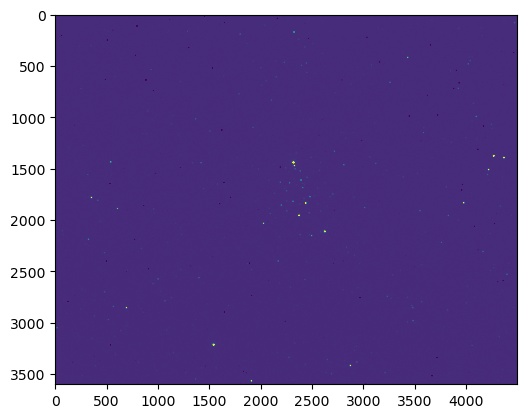

In [54]:
plt.imshow(processed_images_wo_dark['M103_003OIII300s.fit'],clim=[0,1000])

# Sky background

In [55]:
[i for i in processed_images_wo_dark.keys() if "Ha" in i]

['M103_003Ha300s.fit',
 'M103_002Ha300s.fit',
 'M103_004Ha300s.fit',
 'M103_001Ha300s.fit']

In [56]:
len(['Ha','OIII','SII'])
len('Ha')

2

In [57]:
skybackground = {}
print('Sky background for target frames in e/s')
for fil in ['Ha']:
    lst_stdskymean = []
    lst_stdskylevel = []
    lst_stdskyrms = []
    for k in [i for i in processed_images_wo_dark.keys() if fil in i]:
        stdskymean, stdskylevel, stdskyrms = (sigma_clipped_stats(processed_images_wo_dark[k], sigma=3, maxiters=20))
        lst_stdskymean.append(stdskymean/expodict[k])
        lst_stdskylevel.append(stdskylevel/expodict[k])
        lst_stdskyrms.append(stdskyrms/expodict[k])

    sk_mean_fil = np.array(lst_stdskymean).mean()
    sk_lvl_fil  = np.array(lst_stdskylevel).mean()
    sk_rms_fil = np.array(lst_stdskyrms).mean()
    print(f'for {fil}: mean = {sk_mean_fil} median = {sk_lvl_fil} rms = {sk_rms_fil}')
    skybackground[fil] = {'mean':sk_mean_fil,'level':sk_lvl_fil,'rms':sk_rms_fil}

Sky background for target frames in e/s
for Ha: mean = 0.38124821825719246 median = 0.3806431820298374 rms = 0.056059634783903925


In [58]:
print('Sky background for target frames in e/s')
for fil in ['OIII']:
    lst_stdskymean = []
    lst_stdskylevel = []
    lst_stdskyrms = []
    for k in [i for i in processed_images_wo_dark.keys() if fil in i]:
        stdskymean, stdskylevel, stdskyrms = (sigma_clipped_stats(processed_images_wo_dark[k], sigma=3, maxiters=20))
        lst_stdskymean.append(stdskymean/expodict[k])
        lst_stdskylevel.append(stdskylevel/expodict[k])
        lst_stdskyrms.append(stdskyrms/expodict[k])

    sk_mean_fil = np.array(lst_stdskymean).mean()
    sk_lvl_fil  = np.array(lst_stdskylevel).mean()
    sk_rms_fil = np.array(lst_stdskyrms).mean()
    print(f'for {fil}: mean = {sk_mean_fil} median = {sk_lvl_fil} rms = {sk_rms_fil}')
    skybackground[fil] = {'mean':sk_mean_fil,'level':sk_lvl_fil,'rms':sk_rms_fil}

Sky background for target frames in e/s
for OIII: mean = 0.4296589813509068 median = 0.42904843409320476 rms = 0.05773344805038252


In [59]:
print('Sky background for target frames in e/s')
for fil in ['SII']:
    lst_stdskymean = []
    lst_stdskylevel = []
    lst_stdskyrms = []
    for k in [i for i in processed_images_wo_dark.keys() if fil in i]:
        stdskymean, stdskylevel, stdskyrms = (sigma_clipped_stats(processed_images_wo_dark[k], sigma=3, maxiters=20))
        lst_stdskymean.append(stdskymean/expodict[k])
        lst_stdskylevel.append(stdskylevel/expodict[k])
        lst_stdskyrms.append(stdskyrms/expodict[k])

    sk_mean_fil = np.array(lst_stdskymean).mean()
    sk_lvl_fil  = np.array(lst_stdskylevel).mean()
    sk_rms_fil = np.array(lst_stdskyrms).mean()
    print(f'for {fil}: mean = {sk_mean_fil} median = {sk_lvl_fil} rms = {sk_rms_fil}')
    skybackground[fil] = {'mean':sk_mean_fil,'level':sk_lvl_fil,'rms':sk_rms_fil}

Sky background for target frames in e/s
for SII: mean = 0.3036904904146875 median = 0.30308828173602803 rms = 0.053304865646152264


In [60]:
skybackgroundcalib = {}
print('Sky background for calibration stars in e/s')
for fil in ['Ha']:
    lst_stdskymean_calib = []
    lst_stdskylevel_calib = []
    lst_stdskyrms_calib = []
    for k in [i for i in processed_calibration_wo_dark.keys() if fil in i]:
        stdskymean_cal, stdskylevel_cal, stdskyrms_cal = (sigma_clipped_stats(processed_calibration_wo_dark[k], sigma=3, maxiters=20))
        lst_stdskymean_calib.append(stdskymean_cal/expodict[k])
        lst_stdskylevel_calib.append(stdskylevel_cal/expodict[k])
        lst_stdskyrms_calib.append(stdskyrms_cal/expodict[k])

    sk_mean_fil_calib = np.array(lst_stdskymean_calib).mean()
    sk_lvl_fil_calib  = np.array(lst_stdskylevel_calib).mean()
    sk_rms_fil_calib = np.array(lst_stdskyrms_calib).mean()
    print(f'for {fil}: mean = {sk_mean_fil_calib} median = {sk_lvl_fil_calib} rms = {sk_rms_fil_calib}')
    skybackgroundcalib[fil] = {'mean':sk_mean_fil_calib,'level':sk_lvl_fil_calib,'rms':sk_rms_fil_calib}

Sky background for calibration stars in e/s
for Ha: mean = 2.1202632655727034 median = 1.9429484667478312 rms = 24.174466147940024


In [61]:
print('Sky background for calibration stars in e/s')
for fil in ['OIII']:
    lst_stdskymean_calib = []
    lst_stdskylevel_calib = []
    lst_stdskyrms_calib = []
    for k in [i for i in processed_calibration_wo_dark.keys() if fil in i]:
        stdskymean_cal, stdskylevel_cal, stdskyrms_cal = (sigma_clipped_stats(processed_calibration_wo_dark[k], sigma=3, maxiters=20))
        lst_stdskymean_calib.append(stdskymean_cal/expodict[k])
        lst_stdskylevel_calib.append(stdskylevel_cal/expodict[k])
        lst_stdskyrms_calib.append(stdskyrms_cal/expodict[k])

    sk_mean_fil_calib = np.array(lst_stdskymean_calib).mean()
    sk_lvl_fil_calib  = np.array(lst_stdskylevel_calib).mean()
    sk_rms_fil_calib = np.array(lst_stdskyrms_calib).mean()
    print(f'for {fil}: mean = {sk_mean_fil_calib} median = {sk_lvl_fil_calib} rms = {sk_rms_fil_calib}')
    skybackgroundcalib[fil] = {'mean':sk_mean_fil_calib,'level':sk_lvl_fil_calib,'rms':sk_rms_fil_calib}

Sky background for calibration stars in e/s
for OIII: mean = 0.3608741306240888 median = 0.16118045821811464 rms = 24.157146691776518


In [62]:
print('Sky background for calibration stars in e/s')
for fil in ['SII']:
    lst_stdskymean_calib = []
    lst_stdskylevel_calib = []
    lst_stdskyrms_calib = []
    for k in [i for i in processed_calibration_wo_dark.keys() if fil in i]:
        stdskymean_cal, stdskylevel_cal, stdskyrms_cal = (sigma_clipped_stats(processed_calibration_wo_dark[k], sigma=3, maxiters=20))
        lst_stdskymean_calib.append(stdskymean_cal/expodict[k])
        lst_stdskylevel_calib.append(stdskylevel_cal/expodict[k])
        lst_stdskyrms_calib.append(stdskyrms_cal/expodict[k])

    sk_mean_fil_calib = np.array(lst_stdskymean_calib).mean()
    sk_lvl_fil_calib  = np.array(lst_stdskylevel_calib).mean()
    sk_rms_fil_calib = np.array(lst_stdskyrms_calib).mean()
    print(f'for {fil}: mean = {sk_mean_fil_calib} median = {sk_lvl_fil_calib} rms = {sk_rms_fil_calib}')
    skybackgroundcalib[fil] = {'mean':sk_mean_fil_calib,'level':sk_lvl_fil_calib,'rms':sk_rms_fil_calib}

Sky background for calibration stars in e/s
for SII: mean = -0.5714915160076955 median = -0.7270265044321885 rms = 24.13931477001842


As target images were taken at higher exposition time compared to standard star frames, they are used to calculate sky background as sky background/bias (or dark current) ratio is greater

## Correct target images and standard star images by sky background

In [63]:
len(processed_images_wo_dark.keys())
len(processed_calibration_wo_dark.keys())

9

In [64]:
processed_images_wo_dark_wo_sky = {}
processed_calibration_wo_dark_wo_sky = {}
for k in list(processed_images_wo_dark.keys()):
    if 'Ha' in k:
        processed_images_wo_dark_wo_sky[k] = processed_images_wo_dark[k] - skybackground['Ha']['mean']*expodict[k]
    elif 'OIII' in k:
        processed_images_wo_dark_wo_sky[k] = processed_images_wo_dark[k] - skybackground['OIII']['mean']*expodict[k]
    elif 'SII' in k:
        processed_images_wo_dark_wo_sky[k] = processed_images_wo_dark[k] - skybackground['SII']['mean']*expodict[k]

for k in list(processed_calibration_wo_dark.keys()):
    if 'Ha' in k:
        processed_calibration_wo_dark_wo_sky[k] = processed_calibration_wo_dark[k] - skybackgroundcalib['Ha']['mean']*expodict[k]
    elif 'OIII' in k:
        processed_calibration_wo_dark_wo_sky[k] = processed_calibration_wo_dark[k] - skybackgroundcalib['OIII']['mean']*expodict[k]
    elif 'SII' in k:
        processed_calibration_wo_dark_wo_sky[k] = processed_calibration_wo_dark[k] - skybackgroundcalib['SII']['mean']*expodict[k]

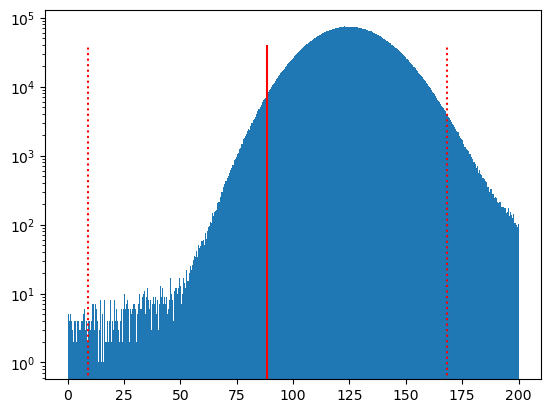

In [65]:
plt.hist(processed_images_wo_dark[list(processed_images_wo_dark.keys())[0]].flatten(),bins=1000,range=[0,200])
plt.vlines(stdskymean,ymin = 0,ymax=40000,color='red',label='stdskylevel')
plt.vlines(stdskymean+5.*stdskyrms,ymin = 0,ymax=40000,linestyles=":",color='red')
plt.vlines(stdskymean-5.*stdskyrms,ymin = 0,ymax=40000,linestyles=":",color='red')
plt.yscale('log')

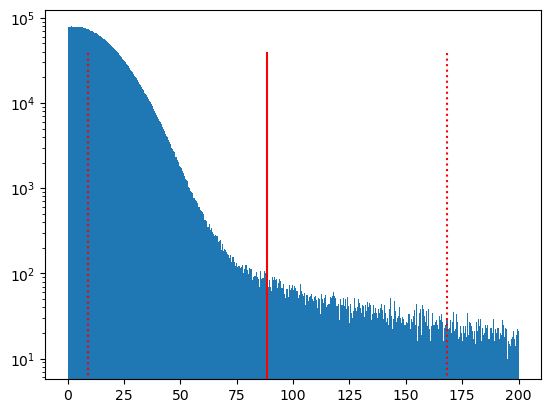

In [66]:
plt.hist(processed_images_wo_dark_wo_sky[list(processed_images_wo_dark.keys())[3]].flatten(),bins=1000,range=[0,200])
plt.vlines(stdskymean,ymin = 0,ymax=40000,color='red',label='stdskylevel')
plt.vlines(stdskymean+5.*stdskyrms,ymin = 0,ymax=40000,linestyles=":",color='red')
plt.vlines(stdskymean-5.*stdskyrms,ymin = 0,ymax=40000,linestyles=":",color='red')
plt.yscale('log')

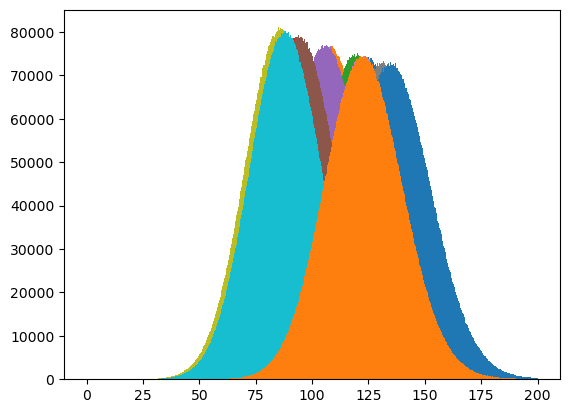

In [67]:
for k in processed_images_wo_dark.keys():
    plt.hist(processed_images_wo_dark[k].flatten(),bins=1000,range=[0,200])

# Standard star

## UniMiB filters creation

In [68]:
#using speclite modulus from https://speclite.readthedocs.io/en/latest/
from speclite import filters

In [69]:
#Code to create .ECSV filters to be used with speclite modulus
reprocess = False
if reprocess:
    Ha_filter_trans = pd.read_csv("./Halpha_3p5nm_Ultra-Narrowband.txt",sep=r"\s+")
    OIII_filter_trans = pd.read_csv("./OIII_4nm_Ultra-Narrowband.txt",sep=r"\s+")
    SII_filter_trans = pd.read_csv("./SII_4nm_Ultra-Narrowband.txt",sep=r"\s+")
    Ha_filter_trans['wave_A']=round(Ha_filter_trans['#Wave_nm']*10,2)
    Ha_filter_trans['T']=round(Ha_filter_trans['Transmission']/100,5)
    OIII_filter_trans['wave_A']=round(OIII_filter_trans['#Wave_nm']*10,2)
    OIII_filter_trans['T']=round(OIII_filter_trans['Transmission']/100,5)
    SII_filter_trans['wave_A']=round(SII_filter_trans['#Wave_nm']*10,2)
    SII_filter_trans['T']=round(SII_filter_trans['Transmission']/100,5)
    Ha_filter_trans.drop(columns=['#Wave_nm','Transmission'],inplace=True)
    OIII_filter_trans.drop(columns=['#Wave_nm','Transmission'],inplace=True)
    SII_filter_trans.drop(columns=['#Wave_nm','Transmission'],inplace=True)
    Ha_filter_trans.to_csv("Ha_filter.ecsv",sep=" ",header=None,index=None)
    OIII_filter_trans.to_csv("OIII_filter_trans.ecsv",sep=" ",header=None,index=None)
    SII_filter_trans.to_csv("SII_filter_trans.ecsv",sep=" ",header=None,index=None)
    #text to prepend to filters to transform txt file into ECSV properly with metadata
    text_to_prepend_Ha = """# %ECSV 1.0
    # ---
    # datatype:
    # - {name: wavelength, unit: Angstrom, datatype: float64}
    # - {name: response, datatype: float64}
    # meta: !!omap
    # - {band_name: Ha}
    # - {group_name: UniMiB}
    wavelength response"""
    text_to_prepend_OIII = """# %ECSV 1.0
    # ---
    # datatype:
    # - {name: wavelength, unit: Angstrom, datatype: float64}
    # - {name: response, datatype: float64}
    # meta: !!omap
    # - {band_name: OIII}
    # - {group_name: UniMiB}
    wavelength response"""
    text_to_prepend_SII = """# %ECSV 1.0
    # ---
    # datatype:
    # - {name: wavelength, unit: Angstrom, datatype: float64}
    # - {name: response, datatype: float64}
    # meta: !!omap
    # - {band_name: SII}
    # - {group_name: UniMiB}
    wavelength response"""
    line_prepender('./Ha_filter.ecsv',text_to_prepend_Ha)
    line_prepender('./OIII_filter_trans.ecsv',text_to_prepend_OIII)
    line_prepender('./SII_filter_trans.ecsv',text_to_prepend_SII)

In [70]:
Bico_filters = filters.load_filters('Ha_filter.ecsv','OIII_filter_trans.ecsv','SII_filter_trans.ecsv')

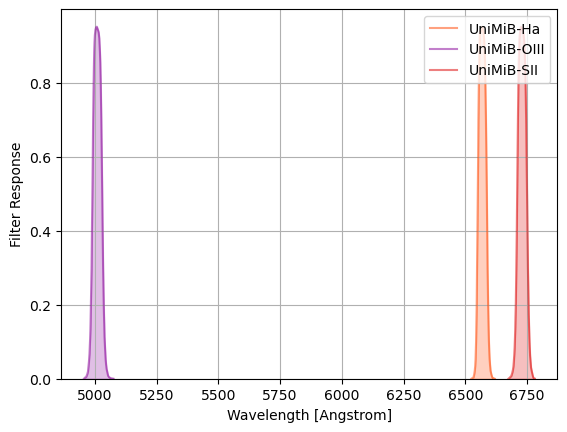

In [71]:
filters.plot_filters(Bico_filters)

In [72]:
Bico_filters.effective_wavelengths

<Quantity [6569.05793053, 5009.15256507, 6730.10447145] Angstrom>

## Standard star magnitude through our filters

In [73]:
HD3360_emissions = pd.read_csv("./fhr153.dat.txt",sep=r"\s+",header=None,names=["wavelength_A","flux_ergs/cm/cm/s/A*10**16","flux_milli_Jy"])
wlen_HD3360 = HD3360_emissions['wavelength_A'].to_numpy() * u.Angstrom 
flux_HD3360 = HD3360_emissions['flux_ergs/cm/cm/s/A*10**16'].to_numpy() * u.erg / (u.cm**2 * u.s * u.Angstrom *10**16)

In [74]:
wlen_HD3360

<Quantity [  925.52  ,   934.78  ,   944.04  , ..., 11969.75  , 11989.7305,
           12009.7402] Angstrom>

In [75]:
flux_HD3360

<Quantity [4.7773e-10, 1.2446e-09, 2.2219e-09, ..., 8.1259e-12, 8.0799e-12,
           8.0340e-12] erg / (Angstrom cm2 s)>

In [76]:
#AB magnitudes convolving HD3360 flux through UniMiB filters
mag_HD3360_unimib = Bico_filters.get_ab_magnitudes(flux_HD3360,wlen_HD3360).as_array()
print(f"HD3360 theoretically shows:\n\
    AB Magnitude {mag_HD3360_unimib['UniMiB-Ha']} through our Ha filter\n\
    AB Magnitude {mag_HD3360_unimib['UniMiB-OIII']} through our OIII filter\n\
    AB Magnitude {mag_HD3360_unimib['UniMiB-SII']} through our SII filter")

HD3360 theoretically shows:
    AB Magnitude [4.02077374] through our Ha filter
    AB Magnitude [3.49282932] through our OIII filter
    AB Magnitude [3.98019712] through our SII filter


## Experimental standard star magnitude

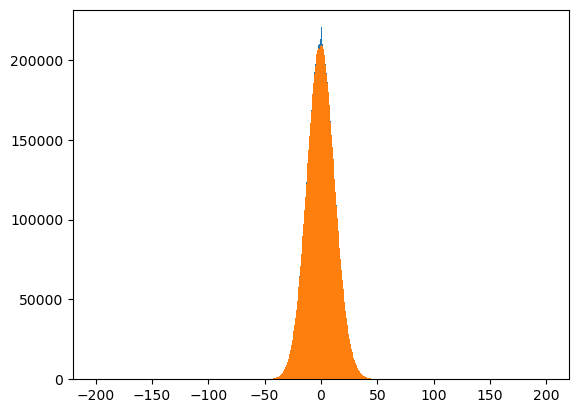

In [77]:
for k in list(processed_calibration_wo_dark_wo_sky.keys())[4:6]:
    plt.hist(processed_calibration_wo_dark_wo_sky[k].flatten(),bins=1000,range=[-200,200])

In [78]:
processed_calibration_wo_dark_wo_sky.keys()

dict_keys(['HD3360_003Ha.fit', 'HD3360_003OIII.fit', 'HD3360_001Ha.fit', 'HD3360_002OIII.fit', 'HD3360_003SII.fit', 'HD3360_002Ha.fit', 'HD3360_001OIII.fit', 'HD3360_001SII.fit', 'HD3360_002SII.fit'])

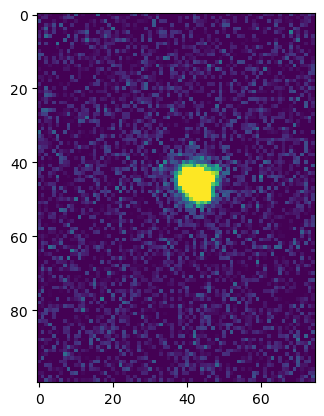

In [79]:

cutoutHa = processed_calibration_wo_dark_wo_sky['HD3360_001Ha.fit'][1685:1785,2275:2350]
cutoutOIII = processed_calibration_wo_dark_wo_sky['HD3360_003OIII.fit'][1685:1785,2275:2350]
cutoutSII = processed_calibration_wo_dark_wo_sky['HD3360_003SII.fit'][1685:1785,2275:2350]
plt.imshow(cutoutHa,clim=[0,100])

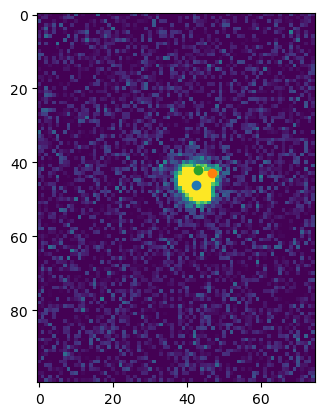

In [80]:
plt.clf()
plt.imshow(cutoutHa,clim=[0,100])
xc1Ha,yc1Ha = photutils.centroids.centroid_com(cutoutHa)
xc2Ha,yc2Ha = photutils.centroids.centroid_2dg(cutoutHa)
xc1OIII,yc1OIII = photutils.centroids.centroid_com(cutoutOIII)
xc2OIII,yc2OIII = photutils.centroids.centroid_2dg(cutoutOIII)
xc1SII,yc1SII = photutils.centroids.centroid_com(cutoutSII)
xc2SII,yc2SII = photutils.centroids.centroid_2dg(cutoutSII)
plt.scatter([xc1Ha],[yc1Ha])
plt.scatter([xc2Ha],[yc2Ha])
plt.scatter([xc2SII],[yc2SII])

In [81]:
xc2SII

42.83273622416552

FWHM  4.220362781018436


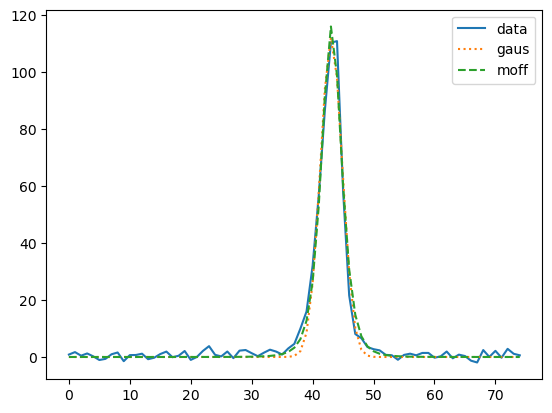

In [82]:
xplane = np.nanmean(cutoutHa,axis=0)
plt.clf()
plt.plot(xplane,label='data')
gaus = models.Gaussian1D(amplitude=40, stddev=4,mean=43)
xaxis = np.arange(len(xplane))
fit_g = fitting.LevMarLSQFitter()
gausfit = fit_g(gaus, xaxis, xplane)
plt.plot(xaxis,gausfit(xaxis),linestyle=":",label='gaus')

moff = models.Moffat1D(amplitude=20,x_0=40, gamma=1, alpha=1)
xaxis = np.arange(len(xplane))
moffit = fit_g(moff, xaxis, xplane)
plt.plot(xaxis,moffit(xaxis),linestyle="--",label='moff')
plt.legend()

xybin = 2
pixtoasc=0.44
print("FWHM ",2.355*gausfit.stddev)#*pixtoasc)


In [83]:
2.355*gausfit.stddev*3

12.661088343055308

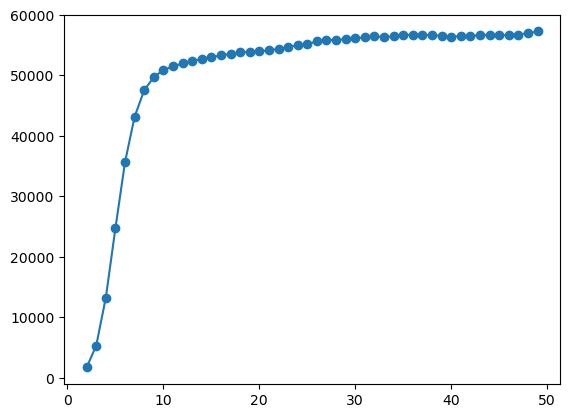

In [84]:
positions = [(xc2Ha,yc2Ha)]
radii = np.arange(2,50,1)
phot = np.zeros(len(radii))

for ii,rr in enumerate(radii):
    aper = photutils.CircularAperture(positions, r=rr)
    phot_table = photutils.aperture_photometry(cutoutHa, aper)
    phot[ii] = phot_table['aperture_sum']
plt.clf()
plt.scatter(radii,phot)
plt.plot(radii,phot)


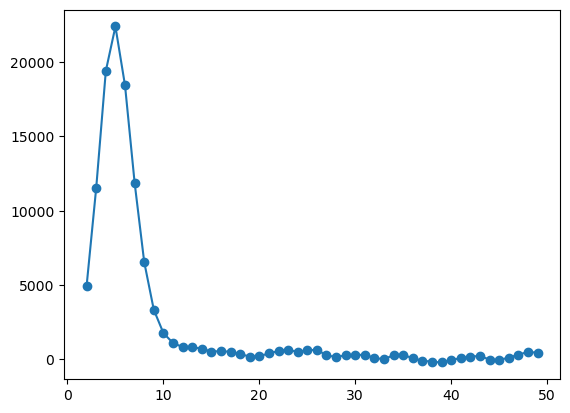

In [85]:
for ii,rr in enumerate(radii):
    aperring = photutils.aperture.CircularAnnulus(positions, rr-1, rr+1)
    #aper = photutils.CircularAperture(positions, r=rr)
    phot_table = photutils.aperture_photometry(cutoutHa, aperring)
    phot[ii] = phot_table['aperture_sum']
plt.clf()
plt.scatter(radii,phot)
plt.plot(radii,phot)


In [86]:
cum_lum=[]
for f in [(xc2Ha,yc2Ha,cutoutHa),(xc2OIII,yc2OIII,cutoutOIII),(xc2SII,yc2SII,cutoutSII)]:
    positions = [f[0],f[1]]
    apermax = photutils.CircularAperture(positions, r=40)
    cum_lum.append(photutils.aperture_photometry(f[2], apermax)['aperture_sum'])
print(cum_lum)

[<Column name='aperture_sum' dtype='float64' length=1>
56438.45194206626, <Column name='aperture_sum' dtype='float64' length=1>
113141.3010717191, <Column name='aperture_sum' dtype='float64' length=1>
65983.00151863944]


In [87]:
f_freq_stand_Ha=3631*10**(-23)*10**(-mag_HD3360_unimib['UniMiB-Ha']/2.5)
f_freq_stand_OIII=3631*10**(-23)*10**(-mag_HD3360_unimib['UniMiB-OIII']/2.5)
f_freq_stand_SII=3631*10**(-23)*10**(-mag_HD3360_unimib['UniMiB-SII']/2.5)
f_lambda_stand_Ha = f_freq_stand_Ha*C/lamb**2
f_lambda_stand_OIII = f_freq_stand_OIII*C/lamb**2
f_lambda_stand_SII = f_freq_stand_SII*C/lamb**2
zero_point_Ha = math.log10(cum_lum[0]/f_lambda_stand_Ha)
zero_point_OIII = math.log10(cum_lum[1]/f_lambda_stand_OIII)
zero_point_SII = math.log10(cum_lum[2]/f_lambda_stand_SII)
print(f"zero point for Ha is: {zero_point_Ha}\n\
zero point for OIII is: {zero_point_OIII}\n\
zero point for SII is: {zero_point_SII}\n\
log10([e/s]/[erg/s/cm^2/A])")


zero point for Ha is: 14.803763015197008
zero point for OIII is: 14.89463132327591
zero point for SII is: 14.855389342935366
log10([e/s]/[erg/s/cm^2/A])


## Local background subtraction

In [88]:
bkg_mean=[]
bkg_std=[]
for f in [(xc2Ha,yc2Ha,cutoutHa),(xc2OIII,yc2OIII,cutoutOIII),(xc2SII,yc2SII,cutoutSII)]:
    #print(f[0],f[1])
    positions = [f[0],f[1]]
    annulus_aperture = photutils.aperture.CircularAnnulus(positions, r_in=20, r_out=28)
    aperstats = photutils.aperture.ApertureStats(f[2], annulus_aperture)
    bkg_mean.append(aperstats.mean)
    bkg_std.append(aperstats.std)
print(bkg_mean) 
print(bkg_std) 

[1.5512923559236842, 0.9707171250942711, 0.4254642694955303]
[11.4746898236397, 12.235931807399533, 11.975325415991758]


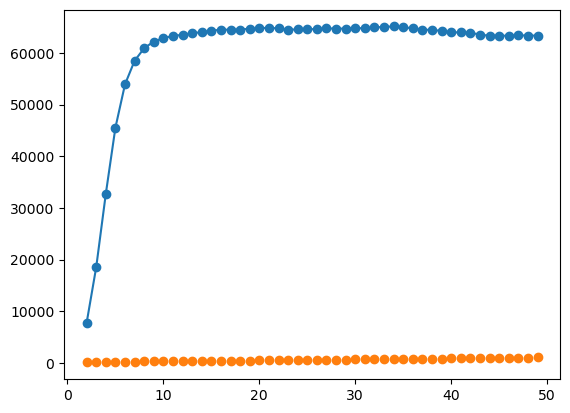

In [89]:
cutout_wo_localBK_Ha = cutoutHa - bkg_mean[0]
cutout_wo_localBK_OIII = cutoutOIII - bkg_mean[1]
cutout_wo_localBK_SII = cutoutSII - bkg_mean[2]
new_cumulative_lum = []
for e,f in enumerate([(xc2Ha,yc2Ha,cutout_wo_localBK_Ha),(xc2OIII,yc2OIII,cutout_wo_localBK_OIII),(xc2SII,yc2SII,cutout_wo_localBK_SII)]):
    for ii,rr in enumerate(radii):
        aper = photutils.CircularAperture((f[0],f[1]), r=rr)
        phot_table = photutils.aperture_photometry(f[2], aper)
        phot[ii] = phot_table['aperture_sum']
    new_cumulative_lum.append(phot_table['aperture_sum'])
    plt.clf()
    plt.scatter(radii,phot)
    plt.scatter(radii,np.sqrt(phot+(bkg_std[e]*np.sqrt(np.pi*radii**2))**2))
    plt.plot(radii,phot)



In [90]:
print(new_cumulative_lum)

[<Column name='aperture_sum' dtype='float64' length=1>
47756.076468011765, <Column name='aperture_sum' dtype='float64' length=1>
106561.32551386661, <Column name='aperture_sum' dtype='float64' length=1>
63338.04600461165]


In [91]:
zero_point_Ha = math.log10(new_cumulative_lum[0]/f_lambda_stand_Ha)
zero_point_OIII = math.log10(new_cumulative_lum[1]/f_lambda_stand_OIII)
zero_point_SII = math.log10(new_cumulative_lum[2]/f_lambda_stand_SII)
print(f"Zero points with local background subtracted:\n\
    zero point for Ha is: {zero_point_Ha}\n\
    zero point for OIII is: {zero_point_OIII}\n\
    zero point for SII is: {zero_point_SII}\n")

Zero points with local background subtracted:
    zero point for Ha is: 14.731216561201121
    zero point for OIII is: 14.86860976869949
    zero point for SII is: 14.837621936680788



# Frames aligning and stacking

In [92]:
#Using astroalign library imported as "asa"

In [93]:
listaimgs = list(processed_images_wo_dark_wo_sky.keys())
listaHa=[i for i in listaimgs if 'Ha' in i]
listaOIII=[i for i in listaimgs if 'OIII' in i]
listaSII=[i for i in listaimgs if 'SII' in i]
processed_images_wo_drk_sky_align = {}
processed_images_wo_drk_sky_align['Ha'],processed_images_wo_drk_sky_align['OIII'],processed_images_wo_drk_sky_align['SII'] = {},{},{}
processed_images_wo_drk_sky_align['Ha'][listaHa[0]] = processed_images_wo_dark_wo_sky[listaHa[0]]
processed_images_wo_drk_sky_align['OIII'][listaOIII[0]] = processed_images_wo_dark_wo_sky[listaOIII[0]]
processed_images_wo_drk_sky_align['SII'][listaSII[0]] = processed_images_wo_dark_wo_sky[listaSII[0]]


In [94]:
for img in listaHa[1:]:
    processed_images_wo_drk_sky_align['Ha'][img] = asa.register(processed_images_wo_dark_wo_sky[img],processed_images_wo_drk_sky_align['Ha'][listaHa[0]])[0]
for img in listaOIII[1:]:
    processed_images_wo_drk_sky_align['OIII'][img] = asa.register(processed_images_wo_dark_wo_sky[img],processed_images_wo_drk_sky_align['OIII'][listaOIII[0]])[0]
for img in listaSII[1:]:
    processed_images_wo_drk_sky_align['SII'][img] = asa.register(processed_images_wo_dark_wo_sky[img],processed_images_wo_drk_sky_align['SII'][listaSII[0]])[0]

In [95]:
stacked_aligned_images = {}
stacked_aligned_images['Ha']=np.zeros((3599,4499))
stacked_aligned_images['OIII']=np.zeros((3599,4499))
stacked_aligned_images['SII']=np.zeros((3599,4499))
for k in processed_images_wo_drk_sky_align.keys():
    for img in processed_images_wo_drk_sky_align[k].keys():
        stacked_aligned_images[k] = np.add(stacked_aligned_images[k],processed_images_wo_drk_sky_align[k][img]) 
    stacked_aligned_images[k]=stacked_aligned_images[k]/len(processed_images_wo_drk_sky_align[k].keys())


stacked_aligned_images['OIII'] = asa.register(stacked_aligned_images['OIII'],stacked_aligned_images['Ha'])[0]
stacked_aligned_images['SII'] = asa.register(stacked_aligned_images['SII'],stacked_aligned_images['Ha'])[0]


In [96]:
#verify correct stacking of aligned images
pixel=(random.randint(0,3599),random.randint(0,4499))
print(pixel)
for k in processed_images_wo_drk_sky_align.keys():
    print("\n",k)
    for img in processed_images_wo_drk_sky_align[k].keys():
        print(processed_images_wo_drk_sky_align[k][img][pixel])
    print("stacked sum =",stacked_aligned_images[k][pixel])

(1626, 4211)

 Ha
-1.5965691079312876
16.801301377333186
-19.053704798434804
-4.574593076678416
stacked sum = -2.1058914014278303

 OIII
1.8625047295578554
18.0351432931561
-8.442860715975897
-19.049064262815904
stacked sum = -5.47795253964192

 SII
27.364817958730555
1.7094265713437469
9.734801170255212
7.654522035919736
stacked sum = -2.616725993528772


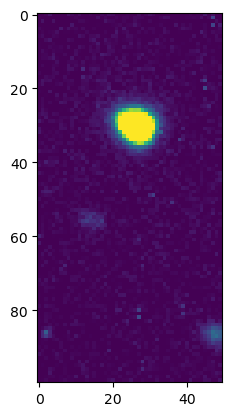

In [97]:
plt.clf()
plt.imshow(stacked_aligned_images['Ha'][2000:2100,2000:2050],clim=[0,300])

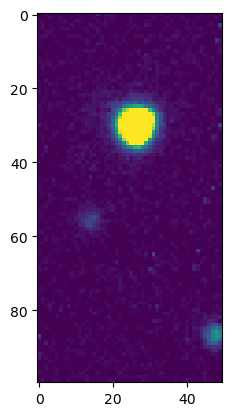

In [98]:
plt.clf()
plt.imshow(stacked_aligned_images['SII'][2000:2100,2000:2050],clim=[0,300])

TODO: \
verify astroalign interpolation

In [99]:
transf, (source_list, target_list) = asa.find_transform(processed_images_wo_drk_sky_align['Ha'][listaHa[0]], processed_images_wo_dark_wo_sky[listaHa[1]])
transf.rotation

0.00039010829442243615

In [100]:
transf.translation

array([  9.50710914, -31.82034289])

# Photometry

## Finding FWHM for few stars

In [101]:
fwhm = {"Ha":[],"OIII":[],"SII":[]}

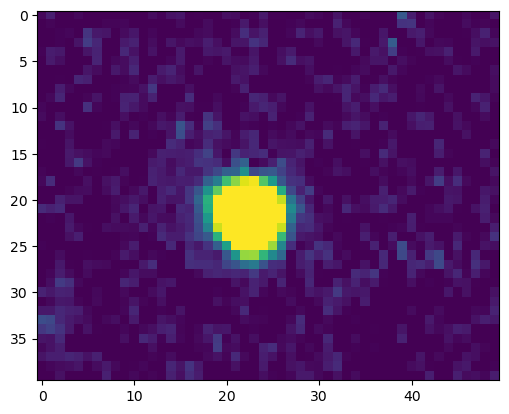

In [102]:
plt.imshow(stacked_aligned_images['OIII'][2120:2160,2360:2410],clim=[0,100])

In [103]:
target_cutout_Ha = stacked_aligned_images['Ha'][2120:2160,2360:2410]
target_cutout_OIII = stacked_aligned_images['OIII'][2120:2160,2360:2410]
target_cutout_SII = stacked_aligned_images['SII'][2120:2160,2360:2410]

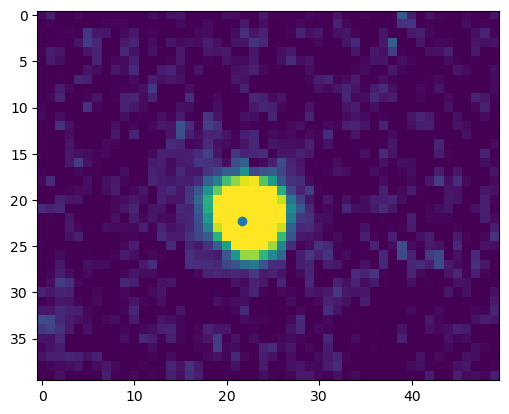

In [104]:
plt.clf()
plt.imshow(target_cutout_OIII,clim=[0,100])
xc2Ha,yc2Ha = photutils.centroids.centroid_2dg(target_cutout_Ha)
xc2OIII,yc2OIII = photutils.centroids.centroid_2dg(target_cutout_OIII)
xc2SII,yc2SII = photutils.centroids.centroid_2dg(target_cutout_SII)
plt.scatter([xc2OIII],[yc2OIII])

FWHM_Ha  5.7715799057930965


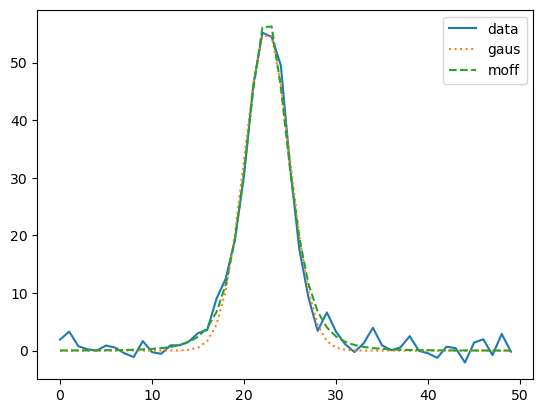

In [105]:
xplane = np.nanmean(target_cutout_Ha,axis=0)
plt.clf()
plt.plot(xplane,label='data')
gaus = models.Gaussian1D(amplitude=40, stddev=4,mean=20)
xaxis = np.arange(len(xplane))
fit_g = fitting.LevMarLSQFitter()
gausfit = fit_g(gaus, xaxis, xplane)
plt.plot(xaxis,gausfit(xaxis),linestyle=":",label='gaus')

moff = models.Moffat1D(amplitude=20,x_0=23, gamma=1, alpha=1)
xaxis = np.arange(len(xplane))
moffit = fit_g(moff, xaxis, xplane)
plt.plot(xaxis,moffit(xaxis),linestyle="--",label='moff')
plt.legend()

plt.legend()

xybin = 2
pixtoasc=0.44
print("FWHM_Ha ",2.355*gausfit.stddev)#*pixtoasc)
fwhm['Ha'].append(2.355*gausfit.stddev)#*pixtoasc)


FWHM_OIII  4.413276603219062


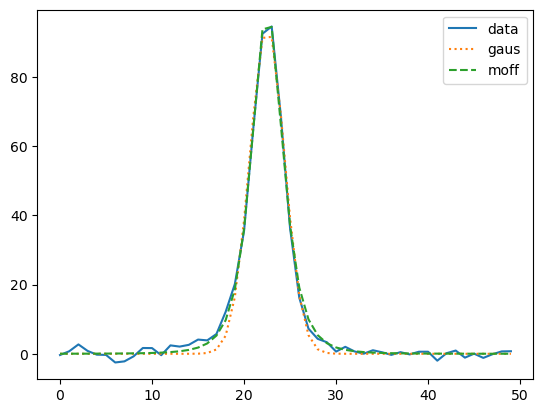

In [106]:
xplane = np.nanmean(target_cutout_OIII,axis=0)
plt.clf()
plt.plot(xplane,label='data')
gaus = models.Gaussian1D(amplitude=60, stddev=4,mean=25)
xaxis = np.arange(len(xplane))
fit_g = fitting.LevMarLSQFitter()
gausfit = fit_g(gaus, xaxis, xplane)
plt.plot(xaxis,gausfit(xaxis),linestyle=":",label='gaus')

moff = models.Moffat1D(amplitude=20,x_0=23, gamma=1, alpha=1)
xaxis = np.arange(len(xplane))
moffit = fit_g(moff, xaxis, xplane)
plt.plot(xaxis,moffit(xaxis),linestyle="--",label='moff')
plt.legend()

plt.legend()

xybin = 2
pixtoasc=0.44
print("FWHM_OIII ",2.355*gausfit.stddev)#*pixtoasc)
fwhm['OIII'].append(2.355*gausfit.stddev)#*pixtoasc)

FWHM_SII  4.983151245618921


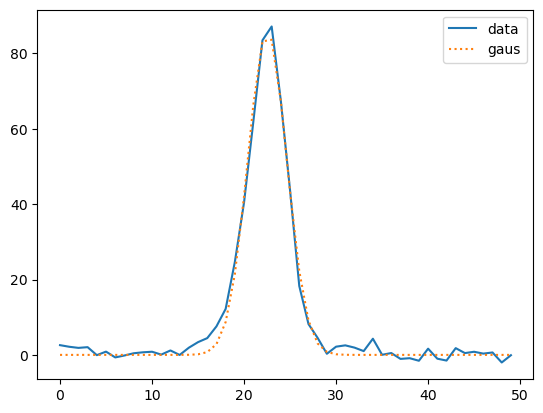

In [107]:
xplane = np.nanmean(target_cutout_SII,axis=0)
plt.clf()
plt.plot(xplane,label='data')
gaus = models.Gaussian1D(amplitude=40, stddev=4,mean=25)
xaxis = np.arange(len(xplane))
fit_g = fitting.LevMarLSQFitter()
gausfit = fit_g(gaus, xaxis, xplane)
plt.plot(xaxis,gausfit(xaxis),linestyle=":",label='gaus')

plt.legend()

xybin = 2
pixtoasc=0.44
print("FWHM_SII ",2.355*gausfit.stddev)#*pixtoasc)
fwhm['SII'].append(2.355*gausfit.stddev)#*pixtoasc)

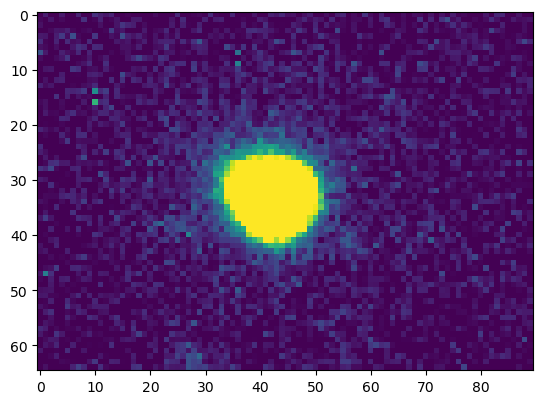

In [108]:
plt.imshow(stacked_aligned_images['Ha'][1920:1985,2330:2420],clim=[0,100])

In [109]:
target_cutout_Ha_2 = stacked_aligned_images['Ha'][1920:1985,2330:2420]
target_cutout_OIII_2 = stacked_aligned_images['OIII'][1920:1985,2330:2420]
target_cutout_SII_2 = stacked_aligned_images['SII'][1920:1985,2330:2420]

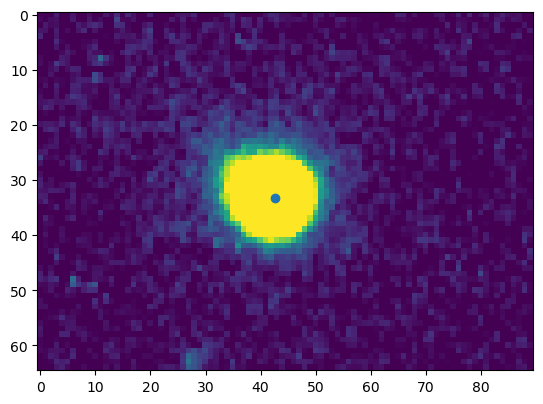

In [110]:
plt.clf()
plt.imshow(target_cutout_OIII_2,clim=[0,100])
xc3Ha,yc3Ha = photutils.centroids.centroid_2dg(target_cutout_Ha_2)
xc3OIII,yc3OIII = photutils.centroids.centroid_2dg(target_cutout_OIII_2)
xc3SII,yc3SII = photutils.centroids.centroid_2dg(target_cutout_SII_2)
plt.scatter([xc3OIII],[yc3OIII])

FWHM  5.68554596297053


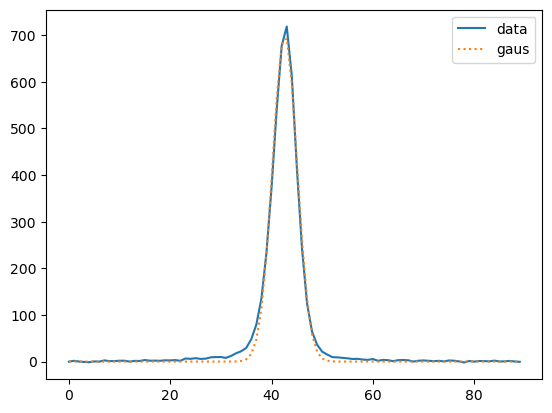

In [111]:
xplane = np.nanmean(target_cutout_Ha_2,axis=0)
plt.clf()
plt.plot(xplane,label='data')
gaus = models.Gaussian1D(amplitude=40, stddev=4)
xaxis = np.arange(len(xplane))
fit_g = fitting.LevMarLSQFitter()
gausfit = fit_g(gaus, xaxis, xplane)
plt.plot(xaxis,gausfit(xaxis),linestyle=":",label='gaus')

plt.legend()

xybin = 2
pixtoasc=0.44
print("FWHM ",2.355*gausfit.stddev)#*pixtoasc)
fwhm['Ha'].append(2.355*gausfit.stddev)#*pixtoasc)

FWHM_OIII  4.577254307636607


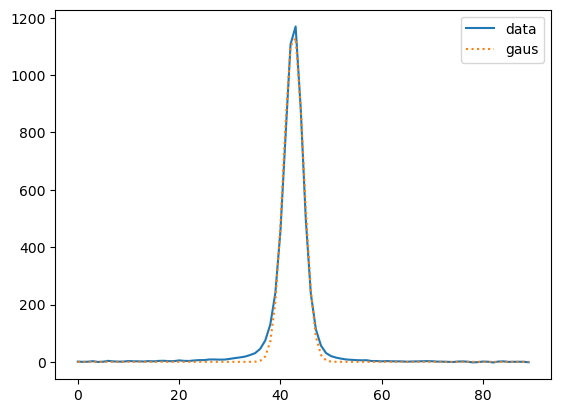

In [112]:
xplane = np.nanmean(target_cutout_OIII_2,axis=0)
plt.clf()
plt.plot(xplane,label='data')
gaus = models.Gaussian1D(amplitude=40, stddev=4)
xaxis = np.arange(len(xplane))
fit_g = fitting.LevMarLSQFitter()
gausfit = fit_g(gaus, xaxis, xplane)
plt.plot(xaxis,gausfit(xaxis),linestyle=":",label='gaus')

plt.legend()

xybin = 2
pixtoasc=0.44
print("FWHM_OIII ",2.355*gausfit.stddev)#*pixtoasc)
fwhm['OIII'].append(2.355*gausfit.stddev)#*pixtoasc)

FWHM_SII  4.988499066038277


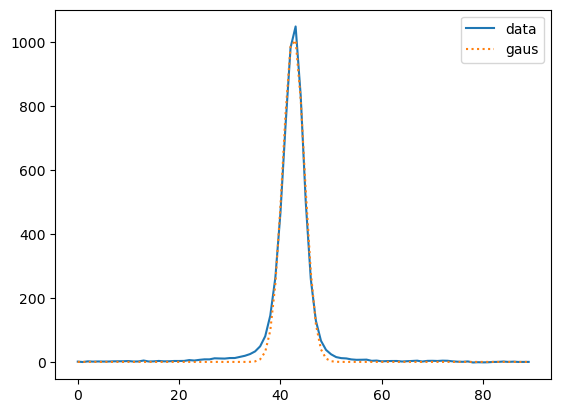

In [113]:
xplane = np.nanmean(target_cutout_SII_2,axis=0)
plt.clf()
plt.plot(xplane,label='data')
gaus = models.Gaussian1D(amplitude=40, stddev=4)
xaxis = np.arange(len(xplane))
fit_g = fitting.LevMarLSQFitter()
gausfit = fit_g(gaus, xaxis, xplane)
plt.plot(xaxis,gausfit(xaxis),linestyle=":",label='gaus')

plt.legend()

xybin = 2
pixtoasc=0.44
print("FWHM_SII ",2.355*gausfit.stddev)#*pixtoasc)
fwhm['SII'].append(2.355*gausfit.stddev)#*pixtoasc)

In [114]:
fwhm

{'Ha': [5.7715799057930965, 5.68554596297053],
 'OIII': [4.413276603219062, 4.577254307636607],
 'SII': [4.983151245618921, 4.988499066038277]}

In [115]:
si=4
thresholdHa = stacked_aligned_images['Ha'].std()*si
thresholdOIII = stacked_aligned_images['OIII'].std()*si
thresholdSII = stacked_aligned_images['SII'].std()*si
print(f"Thresholds: Ha={thresholdHa}, OIII={thresholdOIII}, SII={thresholdSII}")

Thresholds: Ha=331.28267894552766, OIII=339.32350188135894, SII=395.3237977423006


In [116]:
HaFinder=photutils.detection.DAOStarFinder(thresholdHa, mean(fwhm['Ha']))
OIIIFinder=photutils.detection.DAOStarFinder(thresholdOIII, mean(fwhm['OIII']))
SIIFinder=photutils.detection.DAOStarFinder(thresholdSII, mean(fwhm['SII']))

In [117]:
HaTable = HaFinder(stacked_aligned_images['Ha'])
OIIITable = OIIIFinder(stacked_aligned_images['OIII'])
SIITable = SIIFinder(stacked_aligned_images['SII'])

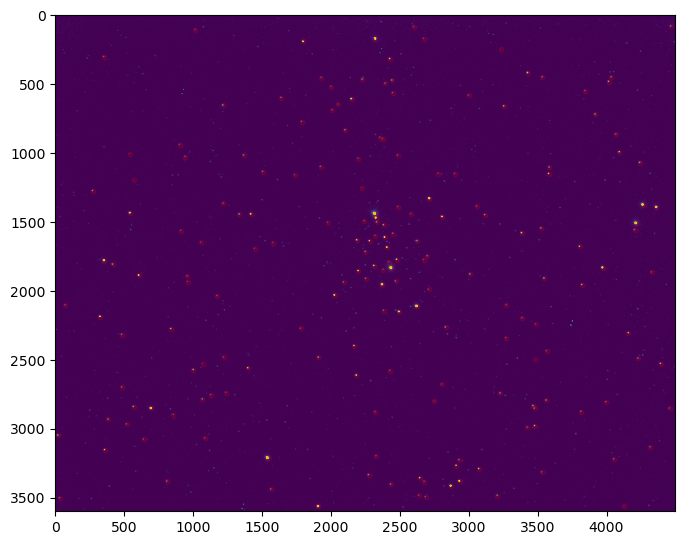

In [118]:
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.imshow(stacked_aligned_images['Ha'],clim=[0,300])
plt.scatter(HaTable['xcentroid'],HaTable['ycentroid'],color='red',s=10.3,alpha=0.15)
fig.savefig(f'stacked_Ha-sigma{si}.png', dpi=300)

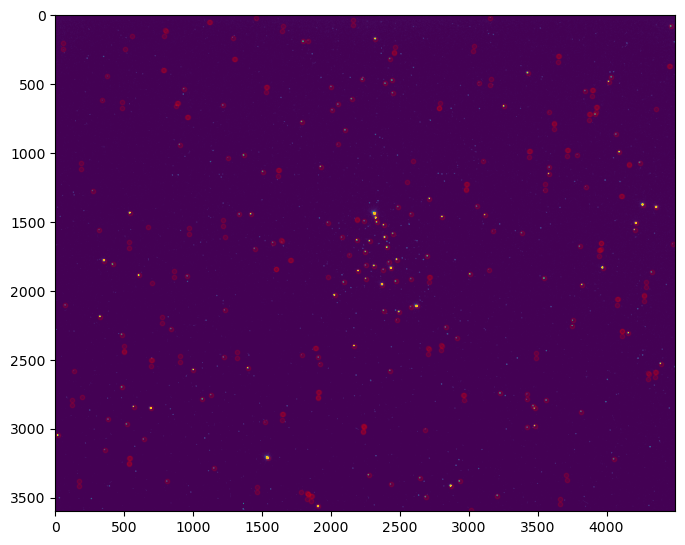

In [119]:
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.imshow(stacked_aligned_images['OIII'],clim=[0,300])
plt.scatter(OIIITable['xcentroid'],OIIITable['ycentroid'],color='red',s=10.3,alpha=0.15)
fig.savefig(f'stacked_OIII-sigma{si}.png', dpi=300)

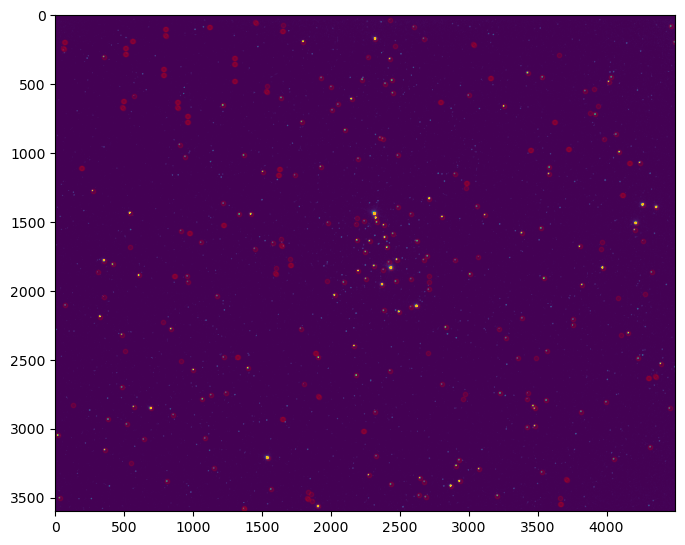

In [120]:
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.imshow(stacked_aligned_images['SII'],clim=[0,300])
plt.scatter(SIITable['xcentroid'],SIITable['ycentroid'],color='red',s=10.3,alpha=0.15)
fig.savefig(f'stacked_SII-sigma{si}.png', dpi=300)

In [121]:
xcentroidSII = SIITable['xcentroid']
ycentroidSII = SIITable['ycentroid']
xcentroidHa = HaTable['xcentroid']
ycentroidHa = HaTable['ycentroid']
xcentroidOIII = OIIITable['xcentroid']
ycentroidOIII = OIIITable['ycentroid']

In [122]:
coordOIII_SII_mean = []
delta = 2.0
for i in range(0, len(xcentroidOIII)) :
  for k in range(0, len(xcentroidSII)) :
    if (xcentroidOIII[i] <= xcentroidSII[k] + delta and xcentroidOIII[i] >= xcentroidSII[k] - delta) and (ycentroidOIII[i] <= ycentroidSII[k] + delta and ycentroidOIII[i] >= ycentroidSII[k] - delta) :
      xOIII_SII = (xcentroidOIII[i] + xcentroidSII[k]) / 2
      yOIII_SII = (ycentroidOIII[i] + ycentroidSII[k]) / 2
      coordOIII_SII_mean.append([xOIII_SII, yOIII_SII])


In [123]:
coordOIII_SII_Ha = []
for i in range(0, len(xcentroidHa)) :
  for k in coordOIII_SII_mean :
    if (abs(k[0]-xcentroidHa[i]) <= delta)  and  (abs(k[1]-ycentroidHa[i] <= delta)) :
      xOIII_SII_Ha = (k[0] + xcentroidHa[i]) / 2
      yOIII_SII_Ha = (k[1] + ycentroidHa[i]) / 2
      coordOIII_SII_Ha.append([xOIII_SII_Ha, yOIII_SII_Ha])
print(len(coordOIII_SII_Ha))

134


In [124]:
arrcoord=np.array(coordOIII_SII_Ha)

In [125]:
HaTable.sort('flux',reverse=True)

In [126]:
x_cen_max = HaTable['xcentroid'][0:20]
y_cen_max = HaTable['ycentroid'][0:20]
coordmax=list(zip(x_cen_max,y_cen_max))

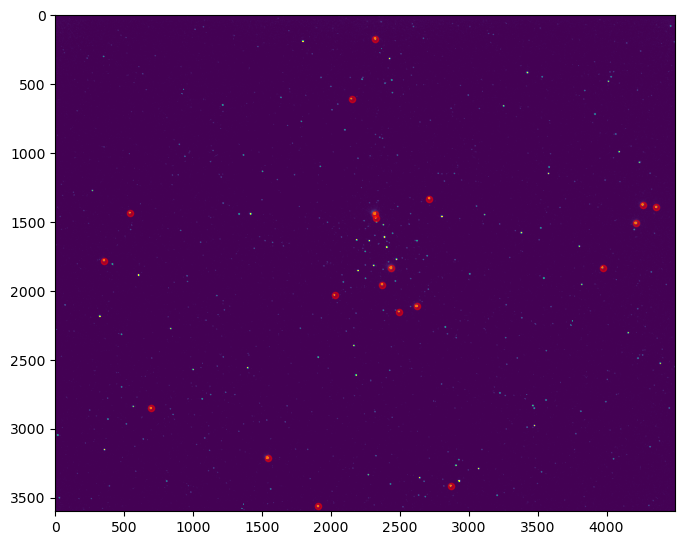

In [127]:
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.imshow(stacked_aligned_images['Ha'],clim=[0,300])
plt.scatter(x_cen_max,y_cen_max,color='red',s=20.3,alpha=0.5)
fig.savefig(f'max_flux_Ha.png', dpi=300)

In [128]:
maxrad=[]
for e,star in enumerate(arrcoord):    
    wid=40
    radii = np.arange(2,50,1)
    phot = np.zeros(len(radii))
    target_cutout_Ha = stacked_aligned_images['Ha'][int(star[1]-wid):int(star[1]+wid),int(star[0]-wid):int(star[0]+wid)]
    plt.clf()
    #plt.imshow(target_cutout_Ha,clim=[0,300])
    new_cumulative_lum=[]
    for ii,rr in enumerate(radii):
        aper = photutils.CircularAperture((wid,wid), r=rr)
        phot_table = photutils.aperture_photometry(target_cutout_Ha, aper)
        phot[ii] = phot_table['aperture_sum']
        new_cumulative_lum.append(phot_table['aperture_sum'])
    a = np.array(phot/np.sqrt(phot+(bkg_std[0]*np.sqrt(np.pi*radii**2))**2))
    bestrad=2+a.argmax()
    maxrad.append(bestrad)
    
    if e<10:
    #plotting part
        plt.scatter(radii,phot/np.sqrt(phot+(bkg_std[0]*np.sqrt(np.pi*radii**2))**2)) #S/N
        plt.clf()
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.imshow(target_cutout_Ha,clim=[0,300])
        circle1 = plt.Circle((wid,wid), bestrad, color='r', fill=False)
        ax1.add_artist(circle1)
        ax1.text(wid*3/2, wid*3/2, f"r={bestrad}",color='white')
        ax2.scatter(radii,phot/np.sqrt(phot+(bkg_std[0]*np.sqrt(np.pi*radii**2))**2))

        ax2.set_xlabel('Radius (pixels)')
        ax2.set_ylabel('S/N')

        plt.tight_layout()
        fig.savefig(f'StarHa x{int(star[0])} - y{int(star[1])}.png', dpi=300)
        #plt.plot(radii,phot)



<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

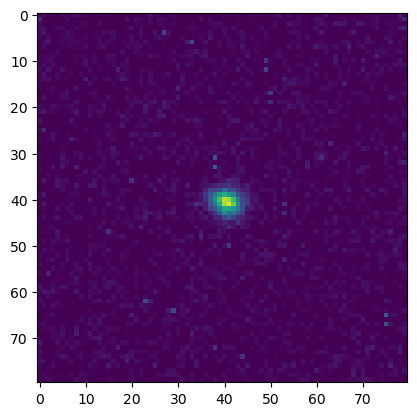

In [129]:
#show single star
star=arrcoord[10]
target_cutout = stacked_aligned_images['Ha'][int(star[1]-wid):int(star[1]+wid),int(star[0]-wid):int(star[0]+wid)]
plt.imshow(target_cutout,clim=[0,300])

In [130]:
#compute mean radius
print(maxrad)
mean_rad = np.mean(maxrad)
print(mean_rad)

mean_rad=round(mean_rad,0)


print("mean radius: ", mean_rad)

#compute the mode for the radius

mode_rad = stats.mode(maxrad,keepdims=True)
median_rad = int(np.median(maxrad))
print("mode radius is: ", mode_rad[0][0])
print("median radius is: ", median_rad)


[5, 9, 6, 6, 6, 5, 5, 5, 5, 5, 4, 5, 5, 6, 4, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 6, 5, 5, 5, 5, 5, 7, 9, 5, 4, 8, 6, 12, 4, 6, 5, 5, 6, 38, 4, 36, 4, 10, 5, 5, 6, 43, 5, 6, 5, 5, 4, 6, 6, 4, 5, 5, 6, 7, 45, 5, 6, 7, 11, 31, 5, 6, 5, 5, 6, 4, 5, 5, 5, 5, 8, 5, 6, 4, 9, 41, 42, 5, 7, 6, 5, 5, 5, 5, 5, 4, 5, 6, 5, 5, 45, 5, 12, 4, 5, 4, 5, 5, 6, 5, 8, 5, 5, 29, 5, 5, 39, 5, 5, 2, 5, 5, 10, 5, 5, 5, 6, 5, 5, 7, 5, 5, 2, 7]
8.0
mean radius:  8.0
mode radius is:  5
median radius is:  5


(array([ 2.,  0., 15., 69., 21.,  6.,  3.,  0.,  3.,  2.,  1.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  2.]),
 array([ 2.  ,  2.86,  3.72,  4.58,  5.44,  6.3 ,  7.16,  8.02,  8.88,
         9.74, 10.6 , 11.46, 12.32, 13.18, 14.04, 14.9 , 15.76, 16.62,
        17.48, 18.34, 19.2 , 20.06, 20.92, 21.78, 22.64, 23.5 , 24.36,
        25.22, 26.08, 26.94, 27.8 , 28.66, 29.52, 30.38, 31.24, 32.1 ,
        32.96, 33.82, 34.68, 35.54, 36.4 , 37.26, 38.12, 38.98, 39.84,
        40.7 , 41.56, 42.42, 43.28, 44.14, 45.  ]),
 <BarContainer object of 50 artists>)

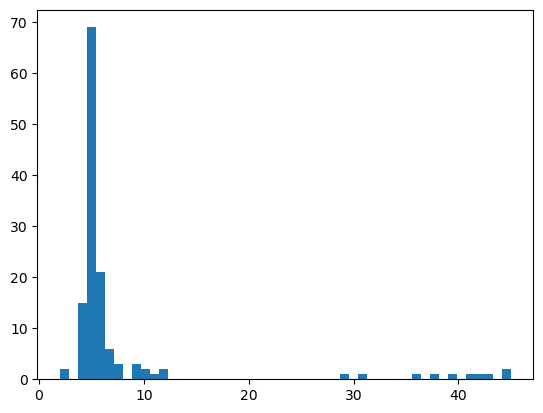

In [131]:
plt.hist(maxrad, bins=50)

In [132]:
#list central pixel brigtness for all stars to eventually filter them out
lum=[]
for st in arrcoord:
    lum.append(stacked_aligned_images['Ha'][int(st[1]),int(st[0])])
lum

[601.932587733801,
 10985.089612224043,
 1994.3730654190285,
 829.4904361529879,
 1746.453321968727,
 500.37624929766025,
 582.9008752197763,
 791.9268479248756,
 671.418341978936,
 445.51698357324534,
 268.3805469018964,
 329.4743236441403,
 396.2991289405311,
 2625.0425323662876,
 259.7237811888223,
 868.591967286161,
 921.4442399362936,
 320.3974205756691,
 708.9615857188355,
 397.2328247232019,
 687.6749848178445,
 399.9056908877273,
 292.06173555756044,
 969.7009640019301,
 589.3158671532852,
 567.4661395159557,
 473.55811930093364,
 666.7198216276383,
 530.4038601684149,
 1012.8404375822054,
 597.5714524591444,
 6058.427258856062,
 14640.17309080081,
 322.1669861972549,
 238.0361654535164,
 8955.822554402,
 3096.1977241025297,
 39192.34718876698,
 233.30755405131475,
 2256.517150057003,
 787.731451762714,
 609.0949049327519,
 2040.6438442679928,
 6569.187451737648,
 260.8507953444835,
 680.1000018170117,
 264.94801843867845,
 20295.526300373815,
 724.8018965513162,
 422.322922504

# Color Magnitude Diagram

## Find magnitude for Ha filter (2D with the moffat)


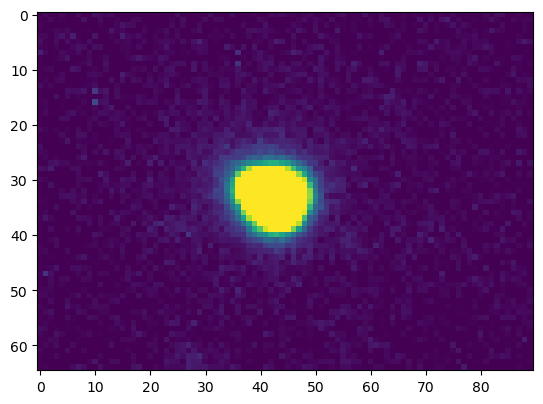

In [133]:
plt.imshow(stacked_aligned_images['Ha'][1920:1985,2330:2420], clim = [0,300])

In [134]:
#fit with a 2D moffat

fit_p = fitting.LevMarLSQFitter()
y, x = np.mgrid[:65, :90]
moff = models.Moffat2D(amplitude=20,x_0=40, y_0=35, gamma=1, alpha=1)
moffit = fit_p(moff, x, y, stacked_aligned_images['Ha'][1920:1985,2330:2420])
print('Moffat paramaters',moffit.amplitude,moffit.x_0,moffit.y_0,moffit.gamma,moffit.alpha)

Moffat paramaters Parameter('amplitude', value=9350.080685086781) Parameter('x_0', value=42.64065369984228) Parameter('y_0', value=33.23921533944923) Parameter('gamma', value=5.3509752736307234) Parameter('alpha', value=3.9871600021378786)


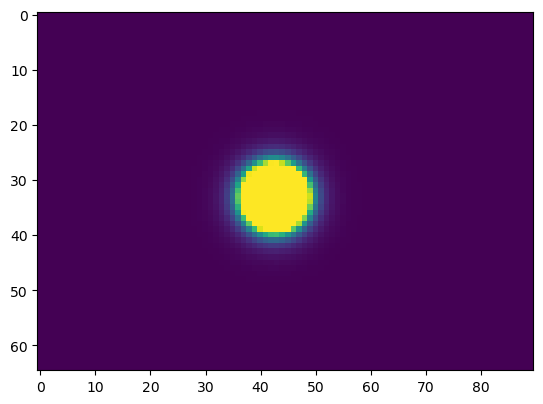

In [135]:
plt.imshow(moffit(x,y), clim = [0,300])

In [136]:
# compute the cumulative function:
radii = np.arange(2,20,0.5)
phot_1star = np.zeros(len(radii))
phot_1star_moffit = np.zeros(len(radii))
#phot_1star_mock_mf = np.zeros(len(radii))
xcen=moffit.x_0[0]
ycen=moffit.y_0[0]
positions = [(xcen,ycen)]

moffit.x_0[0]

42.64065369984228

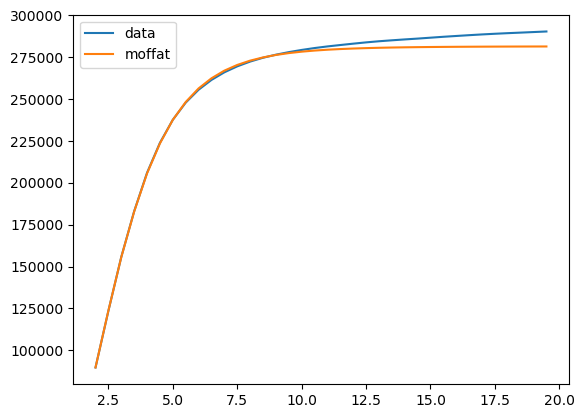

In [137]:
for ii, rr in enumerate(radii):

  aper = photutils.aperture.CircularAperture(positions, r=rr)
  phot_table = photutils.aperture.aperture_photometry((target_cutout_Ha_2), aper)
  phot_1star[ii] = phot_table['aperture_sum']
  phot_table = photutils.aperture.aperture_photometry(moffit(x,y), aper)
  phot_1star_moffit[ii] = phot_table['aperture_sum']
  #phot_table = photutils.aperture.aperture_photometry(mock_image_mf, aper)
  #phot_1star_mock_mf[ii] = phot_table['aperture_sum']

plt.plot(radii, phot_1star,label='data')
#plt.plot(radii, phot_1star_mock,label='gaussian')
plt.plot(radii, phot_1star_moffit,label='moffat')
plt.legend()
plt.show()

In [138]:
moffat_rad = phot_1star_moffit[median_rad]
#radius 12 is chosen as a radius at which the cumulative function is almost flat
moffat_tot = phot_1star_moffit[12]

correction_exp = moffat_rad/moffat_tot
correction_exp

0.8188800107259877

In [139]:
data_mean_rad = phot_1star[median_rad]
#radius 12 is chosen as a radius at which the cumulative function is almost flat
data_max_rad  = phot_1star[12]

correction_data = data_mean_rad/data_max_rad
correction_data

0.8218816212804853

In [140]:
fluxtot=[]
for e, coord in enumerate(arrcoord):

  aper = photutils.aperture.CircularAperture(coord, r=median_rad)
  phot_table = photutils.aperture.aperture_photometry((stacked_aligned_images['Ha']), aper)
  fluxtot.append(phot_table['aperture_sum'].value[0]/correction_exp)

In [141]:
fluxtot

[19635.815516747443,
 392760.7175447009,
 61512.43530332944,
 29432.022061426538,
 64942.317927282405,
 16231.05134685166,
 18915.789684966694,
 23796.95436457332,
 25924.252207221707,
 13565.677751802037,
 8345.531364820174,
 11343.615923308926,
 12929.986828280416,
 81507.16192567899,
 8018.328243726796,
 25776.29816273402,
 29531.039459256313,
 9876.244796131012,
 23614.32744648915,
 13938.73569845004,
 20940.014802979276,
 12826.084554071405,
 9044.892256583027,
 33669.06080464212,
 18539.407306872232,
 24250.486746755098,
 15357.880245949746,
 21765.57892147459,
 17547.823104634062,
 32371.12118528984,
 19874.542601944955,
 188893.72202886766,
 524317.5617500858,
 10812.530854147679,
 8201.917032961175,
 327547.2307137736,
 97313.85408777944,
 1604531.6216265121,
 7292.238000370188,
 71736.55473137886,
 25094.84481734134,
 21052.454718750992,
 71447.28745789579,
 215276.56461988346,
 8291.128126898733,
 23518.434568253735,
 7655.934687983912,
 802101.1893692894,
 24583.56565638700

In [142]:
#find the flux by dividing data of e counts found with moffat for the zero point, in erg/cm^s/s/ang

flux_Ha_true = np.divide(fluxtot, 10**zero_point_Ha)
flux_Ha_true

array([ 3.64613196e-11,  7.29308850e-10,  1.14221106e-10,  5.46516828e-11,
        1.20589980e-10,  3.01390869e-11,  3.51243192e-11,  4.41880479e-11,
        4.81381811e-11,  2.51898125e-11,  1.54966360e-11,  2.10637141e-11,
        2.40094118e-11,  1.51348880e-10,  1.48890596e-11,  4.78634485e-11,
        5.48355461e-11,  1.83389846e-11,  4.38489320e-11,  2.58825357e-11,
        3.88830589e-11,  2.38164780e-11,  1.67952641e-11,  6.25193481e-11,
        3.44254230e-11,  4.50302024e-11,  2.85177144e-11,  4.04160310e-11,
        3.25841718e-11,  6.01092322e-11,  3.69046067e-11,  3.50752652e-10,
        9.73593898e-10,  2.00775538e-11,  1.52299617e-11,  6.08215342e-10,
        1.80699983e-10,  2.97941993e-09,  1.35407984e-11,  1.33206051e-10,
        4.65980726e-11,  3.90918461e-11,  1.32668917e-10,  3.99742379e-10,
        1.53956158e-11,  4.36708706e-11,  1.42161389e-11,  1.48940429e-09,
        4.56486894e-11,  3.08244893e-11,  1.00249065e-10,  2.80987618e-14,
        2.89051072e-11,  

In [143]:
lamb_Ha,lamb_OIII,lamb_SII = Bico_filters.effective_wavelengths.value


In [144]:
#find the magnitude for Ha

flux_Ha_freq = np.multiply(lamb_Ha**2/C, flux_Ha_true)
mag_Ha = np.multiply(-2.5, np.log(flux_Ha_freq/(3631*10**(-23))))
mag_Ha

/var/folders/9h/wspygsdd64nc8w1bt957q7t40000gn/T/ipykernel_32448/148302410.py:4: RuntimeWarning: invalid value encountered in log
  mag_Ha = np.multiply(-2.5, np.log(flux_Ha_freq/(3631*10**(-23))))


array([ 1.05919397e+01,  3.10232634e+00,  7.73722937e+00,  9.58011959e+00,
        7.60157911e+00,  1.10680124e+01,  1.06853352e+01,  1.01114337e+01,
        9.89738048e+00,  1.15164705e+01,  1.27310122e+01,  1.19636900e+01,
        1.16364548e+01,  7.03360052e+00,  1.28310029e+01,  9.91168927e+00,
        9.57172302e+00,  1.23099969e+01,  1.01306937e+01,  1.14486485e+01,
        1.04311730e+01,  1.16566254e+01,  1.25298272e+01,  9.24387941e+00,
        1.07355813e+01,  1.00642360e+01,  1.12062560e+01,  1.03345033e+01,
        1.08730030e+01,  9.34216100e+00,  1.05617286e+01,  4.93236641e+00,
        2.38008392e+00,  1.20835634e+01,  1.27744080e+01,  3.55624710e+00,
        6.59047434e+00, -4.16140165e-01,  1.30683015e+01,  7.35282664e+00,
        9.97867166e+00,  1.04177848e+01,  7.36292791e+00,  4.60551888e+00,
        1.27473626e+01,  1.01408663e+01,  1.29466249e+01,  1.31724083e+00,
        1.00301324e+01,  1.10117959e+01,  8.06342524e+00,  2.85126440e+01,
        1.11725239e+01,  

In [145]:
flux_Ha_freq

array([ 5.24829046e-22,  1.04977678e-20,  1.64411367e-21,  7.86663536e-22,
        1.73578809e-21,  4.33825995e-22,  5.05584087e-22,  6.36048594e-22,
        6.92907333e-22,  3.62585486e-22,  2.23060624e-22,  3.03193882e-22,
        3.45594643e-22,  2.17853575e-21,  2.14315090e-22,  6.88952795e-22,
        7.89310088e-22,  2.63973764e-22,  6.31167315e-22,  3.72556635e-22,
        5.59687882e-22,  3.42817527e-22,  2.41753248e-22,  8.99911748e-22,
        4.95524082e-22,  6.48170677e-22,  4.10487745e-22,  5.81753684e-22,
        4.69020869e-22,  8.65220222e-22,  5.31209780e-22,  5.04877996e-21,
        1.40140391e-20,  2.88998960e-22,  2.19222079e-22,  8.75473191e-21,
        2.60101941e-21,  4.28861638e-20,  1.94908040e-22,  1.91738548e-21,
        6.70738807e-22,  5.62693193e-22,  1.90965390e-21,  5.75394457e-21,
        2.21606526e-22,  6.28604275e-22,  2.04628980e-22,  2.14386819e-20,
        6.57073260e-22,  4.43691767e-22,  1.44299828e-21,  4.04457286e-25,
        4.16063929e-22,  

## Find magnitude for SII filter (2D with the moffat)

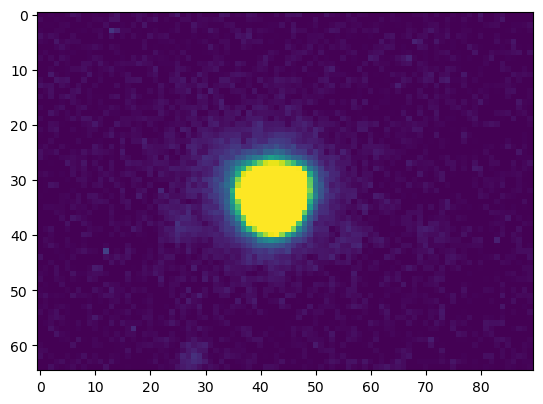

In [146]:
plt.imshow(stacked_aligned_images['SII'][1920:1985,2330:2420], clim = [0,300])

Moffat paramaters Parameter('amplitude', value=12530.561941773936) Parameter('x_0', value=42.59701542642107) Parameter('y_0', value=33.271514373006056) Parameter('gamma', value=5.981603508078501) Parameter('alpha', value=4.912642672514247)


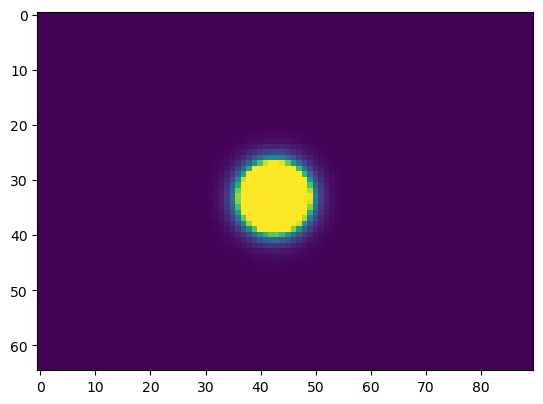

In [147]:
#fit with a 2D moffat

fit_p = fitting.LevMarLSQFitter()
y, x = np.mgrid[:65, :90]
moff = models.Moffat2D(amplitude=20,x_0=40, y_0=35, gamma=1, alpha=1)
moffit = fit_p(moff, x, y, stacked_aligned_images['SII'][1920:1985,2330:2420])
print('Moffat paramaters',moffit.amplitude,moffit.x_0,moffit.y_0,moffit.gamma,moffit.alpha)

plt.imshow(moffit(x,y), clim = [0,300])

In [148]:
# compute the cumulative function:
radii = np.arange(2,20,0.5)
phot_1star = np.zeros(len(radii))
phot_1star_moffit = np.zeros(len(radii))
#phot_1star_mock_mf = np.zeros(len(radii))
xcen=moffit.x_0[0]
ycen=moffit.y_0[0]
positions = [(xcen,ycen)]

moffit.x_0[0]

42.59701542642107

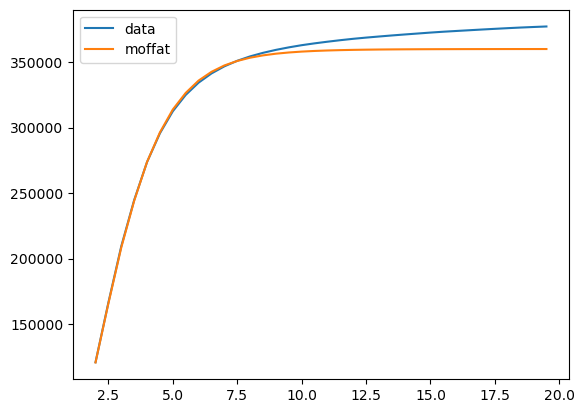

In [149]:
for ii, rr in enumerate(radii):

  aper = photutils.aperture.CircularAperture(positions, r=rr)
  phot_table = photutils.aperture.aperture_photometry((target_cutout_SII_2), aper)
  phot_1star[ii] = phot_table['aperture_sum']
  phot_table = photutils.aperture.aperture_photometry(moffit(x,y), aper)
  phot_1star_moffit[ii] = phot_table['aperture_sum']
  #phot_table = photutils.aperture.aperture_photometry(mock_image_mf, aper)
  #phot_1star_mock_mf[ii] = phot_table['aperture_sum']

plt.plot(radii, phot_1star,label='data')
#plt.plot(radii, phot_1star_mock,label='gaussian')
plt.plot(radii, phot_1star_moffit,label='moffat')
plt.legend()
plt.show()

In [150]:
moffat_rad = phot_1star_moffit[median_rad]
#radius 12 is chosen as a radius at which the cumulative function is almost flat
moffat_tot = phot_1star_moffit[12]

correction_exp = moffat_rad/moffat_tot
correction_exp

0.8385558717191354

In [151]:
data_mean_rad = phot_1star[median_rad]
#radius 12 is chosen as a radius at which the cumulative function is almost flat
data_max_rad  = phot_1star[12]

correction_data = data_mean_rad/data_max_rad
correction_data

0.8342972097427341

In [152]:
fluxtot=[]
for e, coord in enumerate(arrcoord):

  aper = photutils.aperture.CircularAperture(coord, r=mean_rad)
  phot_table = photutils.aperture.aperture_photometry((stacked_aligned_images['SII']), aper)
  fluxtot.append(phot_table['aperture_sum'].value[0]/correction_exp)

fluxtot

[30563.738191587403,
 585300.5673430919,
 93469.68726512669,
 44973.13026588121,
 100262.0135959371,
 25898.89820963718,
 28780.744908122622,
 36509.95922280255,
 40167.66083619461,
 20655.152274731325,
 12392.353561151296,
 16658.87734942966,
 19121.206514784062,
 98333.24112794758,
 12736.588401311867,
 38557.84361471965,
 50504.40563687893,
 14642.022200155476,
 37780.82686847795,
 22909.034109428685,
 33554.28020857264,
 19590.0760258958,
 15813.225560901501,
 58522.138686588056,
 28401.833137743837,
 40830.11338796895,
 23753.367794706537,
 33320.09783454149,
 28277.246070928304,
 48053.95221600275,
 29815.48613115141,
 194112.55075366484,
 816603.7418843388,
 17968.90999114221,
 12819.691142513275,
 507065.3552948329,
 143869.57798903086,
 2140580.5800829427,
 11859.617715289647,
 107539.7191099462,
 37698.215199945,
 36458.35215882507,
 62098.03525814028,
 264353.3180213273,
 12555.922915607447,
 34555.315612301514,
 11943.869216530627,
 1081650.6839630147,
 36996.243375147234,


In [153]:
#find the flux by dividing data of e counts found with moffat for the zero point, in erg/cm^s/s/ang

flux_SII_true = np.divide(fluxtot, 10**zero_point_SII)
flux_SII_true

array([ 4.44206116e-11,  8.50661952e-10,  1.35846625e-10,  6.53628801e-11,
        1.45718431e-10,  3.76408439e-11,  4.18292515e-11,  5.30627082e-11,
        5.83787249e-11,  3.00197081e-11,  1.80107525e-11,  2.42116169e-11,
        2.77903077e-11,  1.42915199e-10,  1.85110553e-11,  5.60390547e-11,
        7.34019044e-11,  2.12803675e-11,  5.49097570e-11,  3.32954464e-11,
        4.87669944e-11,  2.84717515e-11,  2.29825667e-11,  8.50546873e-11,
        4.12785501e-11,  5.93415177e-11,  3.45225810e-11,  4.84266393e-11,
        4.10974783e-11,  6.98404736e-11,  4.33331199e-11,  2.82118574e-10,
        1.18683250e-09,  2.61155873e-11,  1.86318348e-11,  7.36956752e-10,
        2.09096630e-10,  3.11106901e-09,  1.72364869e-11,  1.56295675e-10,
        5.47896912e-11,  5.29877037e-11,  9.02518105e-11,  3.84204838e-10,
        1.82484803e-11,  5.02218755e-11,  1.73589360e-11,  1.57204543e-09,
        5.37694620e-11,  3.83698000e-11,  9.38113627e-11, -5.95577400e-14,
        3.34242735e-11,  

In [154]:
#find the magnitude for SII

flux_SII_freq = np.multiply(lamb_SII**2/C, flux_SII_true)
mag_SII = np.multiply(-2.5, np.log(flux_SII_freq/(3631*10**(-23))))
mag_SII

/var/folders/9h/wspygsdd64nc8w1bt957q7t40000gn/T/ipykernel_32448/1154998828.py:4: RuntimeWarning: invalid value encountered in log
  mag_SII = np.multiply(-2.5, np.log(flux_SII_freq/(3631*10**(-23))))


array([ 9.97720946,  2.5964314 ,  7.18265221,  9.01158215,  7.00727793,
       10.39124409, 10.1274787 ,  9.53278247,  9.29408963, 10.95683318,
       12.23404608, 11.49438704, 11.14975014,  7.05583984, 12.16554809,
        9.3963463 ,  8.72159373, 11.81700609,  9.44724079, 10.69791683,
        9.74383408, 11.08918738, 11.62462854,  8.35323236, 10.16061094,
        9.25319546, 10.60743436,  9.76134328, 10.17160152,  8.8459342 ,
       10.03917535,  5.35564979,  1.76386026, 11.30513756, 12.14928927,
        2.95514541,  6.10447721, -0.64533576, 12.34389726,  6.83209451,
        9.45271329,  9.53631873,  8.20495929,  4.58352883, 12.20126391,
        9.67034169, 12.32619989,  1.06113625,  9.49970422, 10.34329171,
        8.10825347,         nan, 10.68826246,  6.80140857,  9.36624048,
        8.75976601, 12.4828113 ,  8.98487523,  8.6077742 , 12.22607857,
       10.29031684, 10.33179166,  7.76761256,  4.17141072, 11.94754067,
        9.48916415,  8.03556149,  4.59002648, -0.29190652, 25.16

## Find magnitude for OIII filter (2D with the moffat)

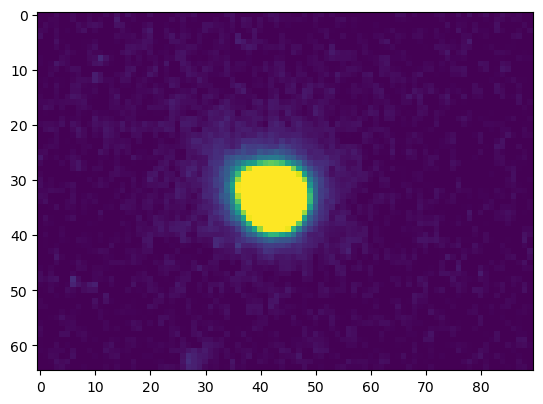

In [155]:
plt.imshow(stacked_aligned_images['OIII'][1920:1985,2330:2420], clim = [0,300])

Moffat paramaters Parameter('amplitude', value=16917.33764946572) Parameter('x_0', value=42.601608134670876) Parameter('y_0', value=33.211601251633) Parameter('gamma', value=4.744361553128569) Parameter('alpha', value=4.194889909471737)


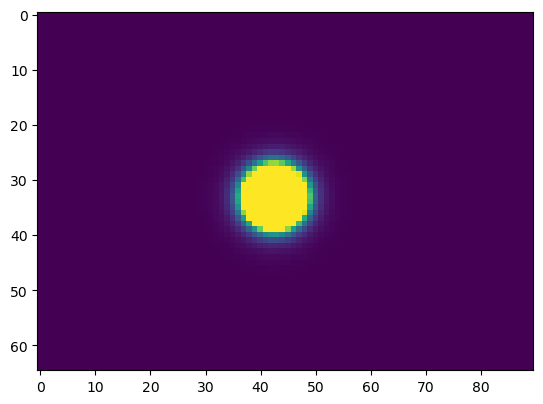

In [156]:
#fit with a 2D moffat

fit_p = fitting.LevMarLSQFitter()
y, x = np.mgrid[:65, :90]
moff = models.Moffat2D(amplitude=20,x_0=40, y_0=35, gamma=1, alpha=1)
moffit = fit_p(moff, x, y, stacked_aligned_images['OIII'][1920:1985,2330:2420])
print('Moffat paramaters',moffit.amplitude,moffit.x_0,moffit.y_0,moffit.gamma,moffit.alpha)

plt.imshow(moffit(x,y), clim = [0,300])

In [157]:
# compute the cumulative function:
radii = np.arange(2,20,0.5)
phot_1star = np.zeros(len(radii))
phot_1star_moffit = np.zeros(len(radii))
#phot_1star_mock_mf = np.zeros(len(radii))
xcen=moffit.x_0[0]
ycen=moffit.y_0[0]
positions = [(xcen,ycen)]

moffit.x_0[0]

42.601608134670876

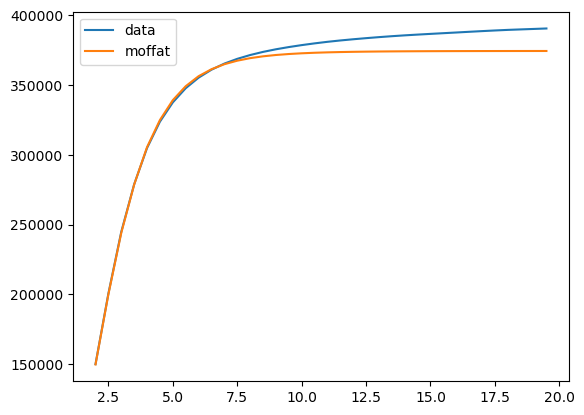

In [158]:
for ii, rr in enumerate(radii):

  aper = photutils.aperture.CircularAperture(positions, r=rr)
  phot_table = photutils.aperture.aperture_photometry((target_cutout_OIII_2), aper)
  phot_1star[ii] = phot_table['aperture_sum']
  phot_table = photutils.aperture.aperture_photometry(moffit(x,y), aper)
  phot_1star_moffit[ii] = phot_table['aperture_sum']
  #phot_table = photutils.aperture.aperture_photometry(mock_image_mf, aper)
  #phot_1star_mock_mf[ii] = phot_table['aperture_sum']

plt.plot(radii, phot_1star,label='data')
#plt.plot(radii, phot_1star_mock,label='gaussian')
plt.plot(radii, phot_1star_moffit,label='moffat')
plt.legend()
plt.show()

In [159]:
moffat_rad = phot_1star_moffit[median_rad]
moffat_tot = max(phot_1star_moffit)

correction_exp = moffat_rad/moffat_tot
correction_exp

0.867945364306219

In [160]:
data_mean_rad = phot_1star[median_rad]
data_max_rad  = phot_1star[12]

correction_data = data_mean_rad/data_max_rad
correction_data

0.8715333827685543

In [161]:
fluxtot=[]
for e, coord in enumerate(arrcoord):

  aper = photutils.aperture.CircularAperture(coord, r=mean_rad)
  phot_table = photutils.aperture.aperture_photometry((stacked_aligned_images['SII']), aper)
  fluxtot.append(phot_table['aperture_sum'].value[0]/correction_exp)

#fluxtot

In [162]:
#find the flux by dividing data of e counts found with moffat for the zero point, in erg/cm^s/s/ang

flux_OIII_true = np.divide(fluxtot, 10**zero_point_OIII)
flux_OIII_true

array([ 3.99609973e-11,  7.65259611e-10,  1.22208282e-10,  5.88007634e-11,
        1.31089006e-10,  3.38618855e-11,  3.76297972e-11,  4.77354692e-11,
        5.25177836e-11,  2.70058747e-11,  1.62025602e-11,  2.17808878e-11,
        2.50002954e-11,  1.28567205e-10,  1.66526350e-11,  5.04130050e-11,
        6.60327086e-11,  1.91439217e-11,  4.93970833e-11,  2.99527448e-11,
        4.38710243e-11,  2.56133255e-11,  2.06752283e-11,  7.65156085e-11,
        3.71343836e-11,  5.33839166e-11,  3.10566810e-11,  4.35648392e-11,
        3.69714904e-11,  6.28288282e-11,  3.89826844e-11,  2.53795235e-10,
        1.06768026e-09,  2.34937088e-11,  1.67612888e-11,  6.62969862e-10,
        1.88104341e-10,  2.79873274e-09,  1.55060271e-11,  1.40604346e-10,
        4.92890715e-11,  4.76679948e-11,  8.11909657e-11,  3.45632532e-10,
        1.64164213e-11,  4.51798424e-11,  1.56161829e-11,  1.41421968e-09,
        4.83712684e-11,  3.45176578e-11,  8.43931562e-11, -5.35784312e-14,
        3.00686383e-11,  

In [163]:
#find the magnitude for OIII

flux_OIII_freq = np.multiply(lamb_OIII**2/C, flux_OIII_true)
mag_OIII = np.multiply(-2.5, np.log(flux_OIII_freq/(3631*10**(-23))))
mag_OIII

/var/folders/9h/wspygsdd64nc8w1bt957q7t40000gn/T/ipykernel_32448/4087387721.py:4: RuntimeWarning: invalid value encountered in log
  mag_OIII = np.multiply(-2.5, np.log(flux_OIII_freq/(3631*10**(-23))))


array([11.71832823,  4.33755016,  8.92377097, 10.75270091,  8.74839669,
       12.13236286, 11.86859747, 11.27390123, 11.03520839, 12.69795195,
       13.97516484, 13.23550581, 12.89086891,  8.7969586 , 13.90666686,
       11.13746506, 10.4627125 , 13.55812486, 11.18835956, 12.43903559,
       11.48495285, 12.83030615, 13.3657473 , 10.09435112, 11.9017297 ,
       10.99431422, 12.34855312, 11.50246204, 11.91272029, 10.58705297,
       11.78029411,  7.09676855,  3.50497903, 13.04625632, 13.89040803,
        4.69626418,  7.84559598,  1.095783  , 14.08501603,  8.57321328,
       11.19383205, 11.2774375 ,  9.94607805,  6.32464759, 13.94238268,
       11.41146045, 14.06731865,  2.80225502, 11.24082299, 12.08441047,
        9.84937223,         nan, 12.42938123,  8.54252733, 11.10735924,
       10.50088478, 14.22393006, 10.725994  , 10.34889296, 13.96719733,
       12.03143561, 12.07291042,  9.50873132,  5.91252948, 13.68865943,
       11.23028291,  9.77668025,  6.33114524,  1.44921224, 26.90


## B-V magnitude (V-R actually)

In [164]:
mag_VR = mag_OIII - mag_Ha
mag_VR

array([ 1.12638853,  1.23522382,  1.1865416 ,  1.17258133,  1.14681758,
        1.0643505 ,  1.18326223,  1.16246749,  1.13782791,  1.18148146,
        1.24415266,  1.27181583,  1.25441409,  1.76335808,  1.07566398,
        1.22577579,  0.89098948,  1.248128  ,  1.05766586,  0.9903871 ,
        1.05377987,  1.17368077,  0.83592006,  0.85047171,  1.16614842,
        0.93007819,  1.14229715,  1.16795872,  1.03971729,  1.24489197,
        1.21856547,  2.16440215,  1.12489511,  0.96269288,  1.11600005,
        1.14001707,  1.25512163,  1.51192317,  1.01671451,  1.22038664,
        1.21516039,  0.85965266,  2.58315015,  1.71912871,  1.19502003,
        1.2705941 ,  1.1206937 ,  1.48501419,  1.21069062,  1.07261457,
        1.78594699,         nan,  1.25685737,  1.26246046,  2.07429173,
        1.25514538,  1.28968508,  1.13405865,  2.40130944,  0.91031207,
        1.18846216,  0.86814115,  1.26314967,  1.29729416,  1.06810845,
        1.2549889 ,  1.23509471,  1.19930734,  1.45588016,  1.72

Find absolute V magnitude

In [165]:
#distance in parsec of m103 cluster (from https://webda.physics.muni.cz/cgi-bin/ocl_page.cgi?cluster=m103)

d = 2194

Mag_abs = mag_OIII + 5 - 5*math.log10(d)
print(Mag_abs, '\nstar found are:', len(Mag_abs))

[ 1.21451122e-02 -7.36863295e+00 -2.78241215e+00 -9.53482204e-01
 -2.95778643e+00  4.26179743e-01  1.62414352e-01 -4.32281885e-01
 -6.70974726e-01  9.91768829e-01  2.26898173e+00  1.52932269e+00
  1.18468579e+00 -2.90922451e+00  2.20048374e+00 -5.68718052e-01
 -1.24347062e+00  1.85194174e+00 -5.17823559e-01  7.32852473e-01
 -2.21230269e-01  1.12412303e+00  1.65956419e+00 -1.61183199e+00
  1.95546586e-01 -7.11868894e-01  6.42370006e-01 -2.03721072e-01
  2.06537173e-01 -1.11913015e+00  7.41109934e-02 -4.60941456e+00
 -8.20120409e+00  1.34007321e+00  2.18422491e+00 -7.00991894e+00
 -3.86058714e+00 -1.06104001e+01  2.37883291e+00 -3.13296984e+00
 -5.12351066e-01 -4.28745619e-01 -1.76010506e+00 -5.38153552e+00
  2.23619956e+00 -2.94722666e-01  2.36113554e+00 -8.90392810e+00
 -4.65360131e-01  3.78227355e-01 -1.85681088e+00             nan
  7.23198111e-01 -3.16365578e+00 -5.98823872e-01 -1.20529834e+00
  2.51774695e+00 -9.80189119e-01 -1.35729015e+00  2.26101422e+00
  3.25252489e-01  3.66727

<function matplotlib.pyplot.show(close=None, block=None)>

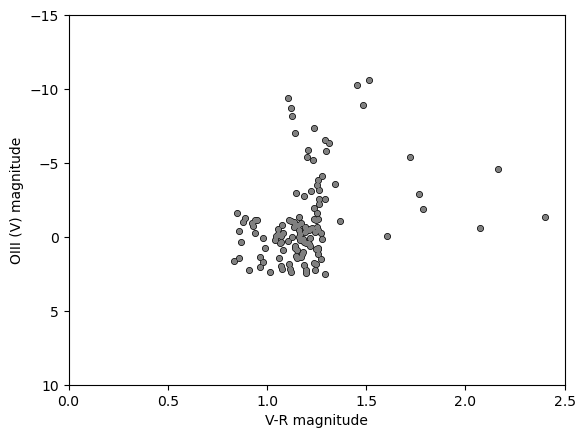

In [166]:
plt.plot(mag_VR, Mag_abs,'o', color='grey', markersize=3, zorder=1)
plt.plot(mag_VR, Mag_abs,'o', color='black', markersize=4, zorder=0)
plt.xlabel('V-R magnitude')
plt.ylabel('OIII (V) magnitude')
plt.gca().invert_yaxis()
plt.xlim(0,2.5)
plt.ylim(10,-15)
plt.show

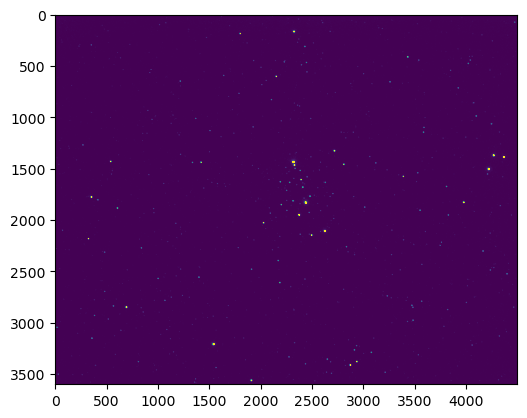

In [169]:
plt.imshow(stacked_aligned_images['Ha'], clim = [0,400])